In [2]:
import torch
print(torch.cuda.is_available())  # Doit retourner True
print(torch.cuda.get_device_name(0))  # Doit afficher le nom de ton GPU


False


RuntimeError: No CUDA GPUs are available

In [1]:
###############################################################################
# 1) PREAMBULE ET IMPORTS
###############################################################################

# On commence par importer nos bibliothèques de base
%matplotlib inline
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Import des modules internes (que vous avez fournis)
# Ajustez selon votre organisation, par ex. si vos scripts sont dans un sous-dossier "src", faites:
#   from src.train import Arguments, train, train_m_models
#   from src.plotter import plot_loss_accs
#   ...
from train import Arguments, train, train_m_models
from trainer_solution import train as train_loop_only  # si vous voulez directement la fonction
from checkpointing import get_extrema_performance_steps, get_all_checkpoints
from plotter import (
    plot_loss_accs, 
    plot_scaling_results,
    analyze_generalization,
    plot_scaling_results  # si vous voulez réutiliser "plot_scaling_results"
)

print("PyTorch version :", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Contrôle du seed (optionnel), 
# vous pouvez aussi laisser train(...) s'en charger.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device=="cuda":
    torch.cuda.manual_seed_all(seed)


PyTorch version : 2.4.1+cu121
Device: cpu


/home/mohamed/miniconda/envs/myenv/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
###############################################################################
# 2) PARTIE 4.1 : Vérification
#    => Entraîner LSTM et GPT hyperparam. par défaut (p=31, r_train=0.5, etc.)
#    => 2 seeds (0 et 42), tracer courbes, etc.
###############################################################################

def run_verification(model_type="lstm", seed=0):
    """
    Exemple de fonction pour exécuter un run d'entraînement 
    avec les paramètres par défaut de la partie 4.1.
    """
    args = Arguments()

    # Paramètres "par défaut" (cf. l'énoncé)
    args.p = 31
    args.operator = "+"
    args.r_train = 0.5
    args.operation_orders = 2   # binaire
    args.train_batch_size = 512
    args.eval_batch_size   = 4096
    args.model = model_type
    args.optimizer = "adamw"
    args.lr = 1e-3
    args.weight_decay = 1e-3
    args.n_steps = 10_000+1
    args.num_layers = 2
    args.embedding_size = 128
    args.hidden_size = 128 if model_type=="lstm" else 128
    args.exp_name = f"verif_{model_type}_seed{seed}"
    args.log_dir  = "./logs_verif"
    args.seed = seed
    args.device = device
    args.verbose = True

    # Lancement
    all_metrics, ckp_path = train(args)
    return all_metrics, ckp_path

# EXEMPLE : 
#  - LSTM seed=0
#  - LSTM seed=42
#  - GPT  seed=0
#  - GPT  seed=42
models = ["lstm", "gpt"]
seeds = [0, 42]

results_part4_1 = {}
for m in models:
    for sd in seeds:
        print(f"\n=== Entraînement {m} (seed={sd}) ===")
        mets, ckp = run_verification(model_type=m, seed=sd)
        results_part4_1[(m, sd)] = (mets, ckp)

# A la fin, on a 4 expériences
# On peut par exemple extraire la perf min, max, etc. ou tracer la courbe 
# (plot_loss_accs est déjà appelé à la fin de train).



=== Entraînement lstm (seed=0) ===
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
model : lstm
optimizer : adamw
lr : 0.001
weight_decay : 0.001
n_steps : 10001
num_layers : 2
embedding_size : 128
hidden_size : 128
exp_name : seed_0
log_dir : ./logs_verif
seed : 0
device : cpu
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
) 

Number of model trainable parameters : 272420
Number of training epochs & steps: 10001 10001

Train loss : 3.551244 | Tra

Training:   0%|          | 1/10001 [00:00<41:44,  3.99it/s]


Train loss : 3.498758 | Train accuracy : 0.000000 | Test loss : 3.500024 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 102/10001 [00:21<25:23,  6.50it/s]


Train loss : 1.700033 | Train accuracy : 0.047917 | Test loss : 1.775719 | Test accuracy : 0.012474 | lr = 0.001


Training:   2%|▏         | 201/10001 [00:31<17:29,  9.33it/s]


Train loss : 0.616452 | Train accuracy : 0.895833 | Test loss : 2.906247 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 301/10001 [00:41<17:31,  9.22it/s]


Train loss : 0.028516 | Train accuracy : 1.000000 | Test loss : 3.768782 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 401/10001 [00:50<17:02,  9.39it/s]


Train loss : 0.009890 | Train accuracy : 1.000000 | Test loss : 3.977988 | Test accuracy : 0.000000 | lr = 0.001


Training:   5%|▌         | 502/10001 [01:00<16:50,  9.40it/s]


Train loss : 0.005320 | Train accuracy : 1.000000 | Test loss : 4.091527 | Test accuracy : 0.000000 | lr = 0.001


Training:   6%|▌         | 601/10001 [01:09<16:26,  9.53it/s]


Train loss : 0.003386 | Train accuracy : 1.000000 | Test loss : 4.169518 | Test accuracy : 0.000000 | lr = 0.001


Training:   7%|▋         | 701/10001 [01:18<17:02,  9.10it/s]


Train loss : 0.002366 | Train accuracy : 1.000000 | Test loss : 4.229026 | Test accuracy : 0.000000 | lr = 0.001


Training:   8%|▊         | 801/10001 [01:28<16:43,  9.17it/s]


Train loss : 0.001755 | Train accuracy : 1.000000 | Test loss : 4.277550 | Test accuracy : 0.000000 | lr = 0.001


Training:   9%|▉         | 902/10001 [01:38<16:02,  9.46it/s]


Train loss : 0.001357 | Train accuracy : 1.000000 | Test loss : 4.318915 | Test accuracy : 0.000000 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:48<17:19,  8.66it/s]


Train loss : 0.001082 | Train accuracy : 1.000000 | Test loss : 4.354849 | Test accuracy : 0.000000 | lr = 0.001


Training:  11%|█         | 1102/10001 [01:58<15:11,  9.76it/s]


Train loss : 0.000882 | Train accuracy : 1.000000 | Test loss : 4.386484 | Test accuracy : 0.000000 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [02:07<15:36,  9.40it/s]


Train loss : 0.000733 | Train accuracy : 1.000000 | Test loss : 4.414848 | Test accuracy : 0.000000 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [02:16<14:59,  9.67it/s]


Train loss : 0.000618 | Train accuracy : 1.000000 | Test loss : 4.440753 | Test accuracy : 0.000000 | lr = 0.001


Training:  14%|█▍        | 1401/10001 [02:26<15:09,  9.46it/s]


Train loss : 0.000528 | Train accuracy : 1.000000 | Test loss : 4.464699 | Test accuracy : 0.000000 | lr = 0.001


Training:  15%|█▌        | 1502/10001 [02:35<15:29,  9.14it/s]


Train loss : 0.000456 | Train accuracy : 1.000000 | Test loss : 4.487021 | Test accuracy : 0.000000 | lr = 0.001


Training:  16%|█▌        | 1601/10001 [02:45<15:55,  8.79it/s]


Train loss : 0.000397 | Train accuracy : 1.000000 | Test loss : 4.508002 | Test accuracy : 0.000000 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [02:55<15:45,  8.78it/s]


Train loss : 0.000348 | Train accuracy : 1.000000 | Test loss : 4.527870 | Test accuracy : 0.000000 | lr = 0.001


Training:  18%|█▊        | 1801/10001 [03:04<14:43,  9.29it/s]


Train loss : 0.000308 | Train accuracy : 1.000000 | Test loss : 4.546790 | Test accuracy : 0.000000 | lr = 0.001


Training:  19%|█▉        | 1901/10001 [03:14<14:34,  9.26it/s]


Train loss : 0.000273 | Train accuracy : 1.000000 | Test loss : 4.564864 | Test accuracy : 0.000000 | lr = 0.001


Training:  20%|██        | 2001/10001 [03:23<13:59,  9.53it/s]


Train loss : 0.000244 | Train accuracy : 1.000000 | Test loss : 4.582163 | Test accuracy : 0.000000 | lr = 0.001


Training:  21%|██        | 2101/10001 [03:32<14:03,  9.36it/s]


Train loss : 0.000219 | Train accuracy : 1.000000 | Test loss : 4.598760 | Test accuracy : 0.002079 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [03:42<18:43,  6.94it/s]


Train loss : 0.000198 | Train accuracy : 1.000000 | Test loss : 4.614731 | Test accuracy : 0.002079 | lr = 0.001


Training:  23%|██▎       | 2302/10001 [03:52<13:37,  9.42it/s]


Train loss : 0.000179 | Train accuracy : 1.000000 | Test loss : 4.630152 | Test accuracy : 0.002079 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [04:02<14:37,  8.66it/s]


Train loss : 0.000163 | Train accuracy : 1.000000 | Test loss : 4.645078 | Test accuracy : 0.002079 | lr = 0.001


Training:  25%|██▌       | 2502/10001 [04:11<12:47,  9.77it/s]


Train loss : 0.000148 | Train accuracy : 1.000000 | Test loss : 4.659560 | Test accuracy : 0.002079 | lr = 0.001


Training:  26%|██▌       | 2601/10001 [04:21<12:57,  9.51it/s]


Train loss : 0.000135 | Train accuracy : 1.000000 | Test loss : 4.673638 | Test accuracy : 0.002079 | lr = 0.001


Training:  27%|██▋       | 2701/10001 [04:30<13:05,  9.29it/s]


Train loss : 0.000124 | Train accuracy : 1.000000 | Test loss : 4.687350 | Test accuracy : 0.002079 | lr = 0.001


Training:  28%|██▊       | 2801/10001 [04:40<12:56,  9.27it/s]


Train loss : 0.000114 | Train accuracy : 1.000000 | Test loss : 4.700726 | Test accuracy : 0.002079 | lr = 0.001


Training:  29%|██▉       | 2900/10001 [04:49<16:03,  7.37it/s]


Train loss : 0.000105 | Train accuracy : 1.000000 | Test loss : 4.713800 | Test accuracy : 0.002079 | lr = 0.001


Training:  30%|███       | 3001/10001 [04:59<13:39,  8.54it/s]


Train loss : 0.000096 | Train accuracy : 1.000000 | Test loss : 4.726604 | Test accuracy : 0.002079 | lr = 0.001


Training:  31%|███       | 3102/10001 [05:09<12:42,  9.04it/s]


Train loss : 0.000089 | Train accuracy : 1.000000 | Test loss : 4.739165 | Test accuracy : 0.002079 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [05:19<12:08,  9.34it/s]


Train loss : 0.000082 | Train accuracy : 1.000000 | Test loss : 4.751503 | Test accuracy : 0.002079 | lr = 0.001


Training:  33%|███▎      | 3301/10001 [05:28<11:46,  9.49it/s]


Train loss : 0.000076 | Train accuracy : 1.000000 | Test loss : 4.763648 | Test accuracy : 0.002079 | lr = 0.001


Training:  34%|███▍      | 3401/10001 [05:37<11:38,  9.45it/s]


Train loss : 0.000071 | Train accuracy : 1.000000 | Test loss : 4.775593 | Test accuracy : 0.002079 | lr = 0.001


Training:  35%|███▌      | 3502/10001 [05:47<12:09,  8.91it/s]


Train loss : 0.000066 | Train accuracy : 1.000000 | Test loss : 4.787360 | Test accuracy : 0.002079 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [05:57<12:44,  8.38it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 4.798956 | Test accuracy : 0.002079 | lr = 0.001


Training:  37%|███▋      | 3702/10001 [06:06<10:56,  9.59it/s]


Train loss : 0.000057 | Train accuracy : 1.000000 | Test loss : 4.810386 | Test accuracy : 0.002079 | lr = 0.001


Training:  38%|███▊      | 3801/10001 [06:16<11:27,  9.02it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.821656 | Test accuracy : 0.002079 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [06:25<10:16,  9.90it/s]


Train loss : 0.000049 | Train accuracy : 1.000000 | Test loss : 4.832763 | Test accuracy : 0.002079 | lr = 0.001


Training:  40%|████      | 4002/10001 [06:34<10:32,  9.48it/s]


Train loss : 0.000046 | Train accuracy : 1.000000 | Test loss : 4.843709 | Test accuracy : 0.002079 | lr = 0.001


Training:  41%|████      | 4101/10001 [06:44<12:53,  7.63it/s]


Train loss : 0.000043 | Train accuracy : 1.000000 | Test loss : 4.854488 | Test accuracy : 0.002079 | lr = 0.001


Training:  42%|████▏     | 4202/10001 [06:54<09:49,  9.84it/s]


Train loss : 0.000040 | Train accuracy : 1.000000 | Test loss : 4.865110 | Test accuracy : 0.002079 | lr = 0.001


Training:  43%|████▎     | 4301/10001 [07:04<12:46,  7.44it/s]


Train loss : 0.000038 | Train accuracy : 1.000000 | Test loss : 4.875581 | Test accuracy : 0.002079 | lr = 0.001


Training:  44%|████▍     | 4402/10001 [07:14<09:34,  9.75it/s]


Train loss : 0.000035 | Train accuracy : 1.000000 | Test loss : 4.885917 | Test accuracy : 0.002079 | lr = 0.001


Training:  45%|████▌     | 4501/10001 [07:23<09:41,  9.47it/s]


Train loss : 0.000033 | Train accuracy : 1.000000 | Test loss : 4.896122 | Test accuracy : 0.002079 | lr = 0.001


Training:  46%|████▌     | 4601/10001 [07:32<09:48,  9.17it/s]


Train loss : 0.000031 | Train accuracy : 1.000000 | Test loss : 4.906188 | Test accuracy : 0.002079 | lr = 0.001


Training:  47%|████▋     | 4701/10001 [07:41<09:17,  9.51it/s]


Train loss : 0.000029 | Train accuracy : 1.000000 | Test loss : 4.916155 | Test accuracy : 0.002079 | lr = 0.001


Training:  48%|████▊     | 4801/10001 [07:51<09:09,  9.47it/s]


Train loss : 0.000027 | Train accuracy : 1.000000 | Test loss : 4.925992 | Test accuracy : 0.002079 | lr = 0.001


Training:  49%|████▉     | 4901/10001 [08:00<08:59,  9.45it/s]


Train loss : 0.000025 | Train accuracy : 1.000000 | Test loss : 4.935742 | Test accuracy : 0.002079 | lr = 0.001


Training:  50%|█████     | 5002/10001 [08:10<09:28,  8.79it/s]


Train loss : 0.000024 | Train accuracy : 1.000000 | Test loss : 4.945406 | Test accuracy : 0.002079 | lr = 0.001


Training:  51%|█████     | 5102/10001 [08:20<08:13,  9.93it/s]


Train loss : 0.000022 | Train accuracy : 1.000000 | Test loss : 4.954974 | Test accuracy : 0.002079 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [08:29<07:52, 10.15it/s]


Train loss : 0.000021 | Train accuracy : 1.000000 | Test loss : 4.964442 | Test accuracy : 0.002079 | lr = 0.001


Training:  53%|█████▎    | 5300/10001 [08:38<08:18,  9.44it/s]


Train loss : 0.000020 | Train accuracy : 1.000000 | Test loss : 4.973814 | Test accuracy : 0.002079 | lr = 0.001


Training:  54%|█████▍    | 5402/10001 [08:48<07:56,  9.66it/s]


Train loss : 0.000019 | Train accuracy : 1.000000 | Test loss : 4.983079 | Test accuracy : 0.002079 | lr = 0.001


Training:  55%|█████▌    | 5501/10001 [08:57<08:58,  8.35it/s]


Train loss : 0.000018 | Train accuracy : 1.000000 | Test loss : 4.992283 | Test accuracy : 0.002079 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [09:06<07:37,  9.62it/s]


Train loss : 0.000017 | Train accuracy : 1.000000 | Test loss : 5.001377 | Test accuracy : 0.002079 | lr = 0.001


Training:  57%|█████▋    | 5702/10001 [09:17<08:18,  8.63it/s]


Train loss : 0.000016 | Train accuracy : 1.000000 | Test loss : 5.010391 | Test accuracy : 0.002079 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [09:26<07:34,  9.25it/s]


Train loss : 0.000015 | Train accuracy : 1.000000 | Test loss : 5.019313 | Test accuracy : 0.002079 | lr = 0.001


Training:  59%|█████▉    | 5901/10001 [09:35<07:05,  9.63it/s]


Train loss : 0.000014 | Train accuracy : 1.000000 | Test loss : 5.028173 | Test accuracy : 0.002079 | lr = 0.001


Training:  60%|██████    | 6001/10001 [09:44<07:25,  8.97it/s]


Train loss : 0.000013 | Train accuracy : 1.000000 | Test loss : 5.036930 | Test accuracy : 0.002079 | lr = 0.001


Training:  61%|██████    | 6101/10001 [09:54<07:01,  9.26it/s]


Train loss : 0.000012 | Train accuracy : 1.000000 | Test loss : 5.045621 | Test accuracy : 0.002079 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [10:03<06:40,  9.47it/s]


Train loss : 0.000012 | Train accuracy : 1.000000 | Test loss : 5.054211 | Test accuracy : 0.002079 | lr = 0.001


Training:  63%|██████▎   | 6301/10001 [10:12<06:32,  9.43it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 5.062722 | Test accuracy : 0.002079 | lr = 0.001


Training:  64%|██████▍   | 6401/10001 [10:22<07:38,  7.86it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 5.071176 | Test accuracy : 0.002079 | lr = 0.001


Training:  65%|██████▌   | 6501/10001 [10:32<06:39,  8.76it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 5.079526 | Test accuracy : 0.002079 | lr = 0.001


Training:  66%|██████▌   | 6602/10001 [10:43<06:14,  9.07it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 5.087828 | Test accuracy : 0.002079 | lr = 0.001


Training:  67%|██████▋   | 6701/10001 [10:52<05:51,  9.38it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 5.096105 | Test accuracy : 0.002079 | lr = 0.001


Training:  68%|██████▊   | 6801/10001 [11:02<05:44,  9.30it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 5.104257 | Test accuracy : 0.002079 | lr = 0.001


Training:  69%|██████▉   | 6901/10001 [11:11<06:12,  8.33it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 5.112378 | Test accuracy : 0.002079 | lr = 0.001


Training:  70%|██████▉   | 7000/10001 [11:21<06:44,  7.43it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.120485 | Test accuracy : 0.002079 | lr = 0.001


Training:  71%|███████   | 7102/10001 [11:33<05:33,  8.69it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.128497 | Test accuracy : 0.002079 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [11:43<05:03,  9.23it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.136427 | Test accuracy : 0.002079 | lr = 0.001


Training:  73%|███████▎  | 7301/10001 [11:53<05:54,  7.62it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.144388 | Test accuracy : 0.002079 | lr = 0.001


Training:  74%|███████▍  | 7400/10001 [12:04<06:23,  6.79it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.152252 | Test accuracy : 0.002079 | lr = 0.001


Training:  75%|███████▌  | 7501/10001 [12:15<06:32,  6.37it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.160061 | Test accuracy : 0.002079 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [12:25<04:22,  9.13it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.167892 | Test accuracy : 0.002079 | lr = 0.001


Training:  77%|███████▋  | 7702/10001 [12:35<04:35,  8.36it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.175748 | Test accuracy : 0.002079 | lr = 0.001


Training:  78%|███████▊  | 7801/10001 [12:45<04:01,  9.12it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.183354 | Test accuracy : 0.002079 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [12:55<03:40,  9.54it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.191045 | Test accuracy : 0.002079 | lr = 0.001


Training:  80%|████████  | 8001/10001 [13:04<03:45,  8.85it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.198683 | Test accuracy : 0.002079 | lr = 0.001


Training:  81%|████████  | 8101/10001 [13:14<03:30,  9.03it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.206378 | Test accuracy : 0.002079 | lr = 0.001


Training:  82%|████████▏ | 8200/10001 [13:25<04:21,  6.89it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.214087 | Test accuracy : 0.002079 | lr = 0.001


Training:  83%|████████▎ | 8302/10001 [13:36<02:51,  9.89it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.221695 | Test accuracy : 0.002079 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [13:46<02:52,  9.29it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.229261 | Test accuracy : 0.002079 | lr = 0.001


Training:  85%|████████▌ | 8502/10001 [13:56<02:34,  9.73it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.236964 | Test accuracy : 0.002079 | lr = 0.001


Training:  86%|████████▌ | 8601/10001 [14:06<02:41,  8.66it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.244383 | Test accuracy : 0.002079 | lr = 0.001


Training:  87%|████████▋ | 8702/10001 [14:16<02:26,  8.85it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.252094 | Test accuracy : 0.002079 | lr = 0.001


Training:  88%|████████▊ | 8801/10001 [14:26<02:15,  8.89it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.259804 | Test accuracy : 0.002079 | lr = 0.001


Training:  89%|████████▉ | 8901/10001 [14:36<02:04,  8.80it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.267239 | Test accuracy : 0.002079 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [14:47<02:13,  7.49it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.274616 | Test accuracy : 0.002079 | lr = 0.001


Training:  91%|█████████ | 9102/10001 [14:57<01:37,  9.27it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.282376 | Test accuracy : 0.002079 | lr = 0.001


Training:  92%|█████████▏| 9200/10001 [15:07<01:30,  8.81it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.289980 | Test accuracy : 0.002079 | lr = 0.001


Training:  93%|█████████▎| 9301/10001 [15:17<01:20,  8.73it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.297311 | Test accuracy : 0.002079 | lr = 0.001


Training:  94%|█████████▍| 9402/10001 [15:27<01:03,  9.36it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.304923 | Test accuracy : 0.002079 | lr = 0.001


Training:  95%|█████████▌| 9502/10001 [15:37<00:54,  9.16it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.312235 | Test accuracy : 0.002079 | lr = 0.001


Training:  96%|█████████▌| 9601/10001 [15:47<00:51,  7.78it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.319681 | Test accuracy : 0.002079 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [15:58<00:33,  8.98it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.327335 | Test accuracy : 0.002079 | lr = 0.001


Training:  98%|█████████▊| 9801/10001 [16:07<00:22,  8.75it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.334618 | Test accuracy : 0.002079 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [16:17<00:10,  9.55it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.342281 | Test accuracy : 0.002079 | lr = 0.001


Training: 100%|█████████▉| 9999/10001 [16:27<00:00, 10.60it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 5.349638 | Test accuracy : 0.002079 | lr = 0.001


Training: 100%|██████████| 10001/10001 [16:27<00:00, 10.13it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 5.349714 | Test accuracy : 0.002079 | lr = 0.001



=== Entraînement lstm (seed=42) ===
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
model : lstm
optimizer : adamw
lr : 0.001
weight_decay : 0.001
n_steps : 10001
num_layers : 2
embedding_size : 128
hidden_size : 128
exp_name : seed_42
log_dir : ./logs_verif
seed : 42
device : cpu
verbose : True
Model : LSTMLM(
  (embedding): Embedding(36, 128, padding_idx=35)
  (lstm): LSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell(
        (input_gate): Linear(in_features=256, out_features=128, bias=True)
        (forget_gate): Linear(in_features=256, out_features=128, bias=True)
        (output_gate): Linear(in_features=256, out_features=128, bias=True)
        (candidate_cell): Linear(in_features=256, out_features=128, bias=True)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
) 

Number of model trainable parameters : 272420
Number of training epochs & steps: 10001 10001

Train loss : 3.590499 | 

Training:   0%|          | 1/10001 [00:00<38:30,  4.33it/s]


Train loss : 3.545757 | Train accuracy : 0.014583 | Test loss : 3.543568 | Test accuracy : 0.016632 | lr = 0.001


Training:   1%|          | 101/10001 [00:22<32:13,  5.12it/s]


Train loss : 1.688539 | Train accuracy : 0.062500 | Test loss : 1.776222 | Test accuracy : 0.004158 | lr = 0.001


Training:   2%|▏         | 201/10001 [00:33<24:24,  6.69it/s]


Train loss : 0.591925 | Train accuracy : 0.897917 | Test loss : 2.809267 | Test accuracy : 0.000000 | lr = 0.001


Training:   3%|▎         | 301/10001 [00:44<20:56,  7.72it/s]


Train loss : 0.025519 | Train accuracy : 1.000000 | Test loss : 3.618328 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 401/10001 [00:54<18:42,  8.55it/s]


Train loss : 0.008821 | Train accuracy : 1.000000 | Test loss : 3.817258 | Test accuracy : 0.002079 | lr = 0.001


Training:   5%|▌         | 501/10001 [01:05<19:41,  8.04it/s]


Train loss : 0.004773 | Train accuracy : 1.000000 | Test loss : 3.931827 | Test accuracy : 0.002079 | lr = 0.001


Training:   6%|▌         | 600/10001 [01:15<19:41,  7.96it/s]


Train loss : 0.003064 | Train accuracy : 1.000000 | Test loss : 4.013895 | Test accuracy : 0.002079 | lr = 0.001


Training:   7%|▋         | 702/10001 [01:25<16:27,  9.41it/s]


Train loss : 0.002156 | Train accuracy : 1.000000 | Test loss : 4.077389 | Test accuracy : 0.002079 | lr = 0.001


Training:   8%|▊         | 801/10001 [01:35<20:22,  7.53it/s]


Train loss : 0.001609 | Train accuracy : 1.000000 | Test loss : 4.129515 | Test accuracy : 0.002079 | lr = 0.001


Training:   9%|▉         | 901/10001 [01:45<16:00,  9.47it/s]


Train loss : 0.001252 | Train accuracy : 1.000000 | Test loss : 4.174162 | Test accuracy : 0.002079 | lr = 0.001


Training:  10%|█         | 1001/10001 [01:55<20:36,  7.28it/s]


Train loss : 0.001004 | Train accuracy : 1.000000 | Test loss : 4.213377 | Test accuracy : 0.002079 | lr = 0.001


Training:  11%|█         | 1102/10001 [02:05<15:45,  9.42it/s]


Train loss : 0.000824 | Train accuracy : 1.000000 | Test loss : 4.248424 | Test accuracy : 0.002079 | lr = 0.001


Training:  12%|█▏        | 1202/10001 [02:15<15:08,  9.68it/s]


Train loss : 0.000689 | Train accuracy : 1.000000 | Test loss : 4.280087 | Test accuracy : 0.002079 | lr = 0.001


Training:  13%|█▎        | 1302/10001 [02:25<15:56,  9.10it/s]


Train loss : 0.000584 | Train accuracy : 1.000000 | Test loss : 4.308960 | Test accuracy : 0.002079 | lr = 0.001


Training:  14%|█▍        | 1402/10001 [02:35<16:17,  8.80it/s]


Train loss : 0.000502 | Train accuracy : 1.000000 | Test loss : 4.335536 | Test accuracy : 0.002079 | lr = 0.001


Training:  15%|█▌        | 1502/10001 [02:46<15:57,  8.88it/s]


Train loss : 0.000435 | Train accuracy : 1.000000 | Test loss : 4.360223 | Test accuracy : 0.002079 | lr = 0.001


Training:  16%|█▌        | 1602/10001 [02:56<15:13,  9.19it/s]


Train loss : 0.000381 | Train accuracy : 1.000000 | Test loss : 4.383340 | Test accuracy : 0.002079 | lr = 0.001


Training:  17%|█▋        | 1702/10001 [03:06<16:09,  8.56it/s]


Train loss : 0.000336 | Train accuracy : 1.000000 | Test loss : 4.405109 | Test accuracy : 0.002079 | lr = 0.001


Training:  18%|█▊        | 1801/10001 [03:16<15:29,  8.82it/s]


Train loss : 0.000298 | Train accuracy : 1.000000 | Test loss : 4.425673 | Test accuracy : 0.004158 | lr = 0.001


Training:  19%|█▉        | 1902/10001 [03:26<14:32,  9.29it/s]


Train loss : 0.000266 | Train accuracy : 1.000000 | Test loss : 4.445125 | Test accuracy : 0.004158 | lr = 0.001


Training:  20%|██        | 2001/10001 [03:36<15:19,  8.70it/s]


Train loss : 0.000238 | Train accuracy : 1.000000 | Test loss : 4.463561 | Test accuracy : 0.004158 | lr = 0.001


Training:  21%|██        | 2101/10001 [03:47<17:46,  7.41it/s]


Train loss : 0.000215 | Train accuracy : 1.000000 | Test loss : 4.481105 | Test accuracy : 0.004158 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [03:57<15:02,  8.65it/s]


Train loss : 0.000194 | Train accuracy : 1.000000 | Test loss : 4.497894 | Test accuracy : 0.004158 | lr = 0.001


Training:  23%|██▎       | 2301/10001 [04:08<15:24,  8.33it/s]


Train loss : 0.000176 | Train accuracy : 1.000000 | Test loss : 4.514049 | Test accuracy : 0.004158 | lr = 0.001


Training:  24%|██▍       | 2402/10001 [04:18<13:55,  9.10it/s]


Train loss : 0.000160 | Train accuracy : 1.000000 | Test loss : 4.529669 | Test accuracy : 0.004158 | lr = 0.001


Training:  25%|██▌       | 2501/10001 [04:28<15:44,  7.94it/s]


Train loss : 0.000146 | Train accuracy : 1.000000 | Test loss : 4.544834 | Test accuracy : 0.004158 | lr = 0.001


Training:  26%|██▌       | 2602/10001 [04:38<14:00,  8.81it/s]


Train loss : 0.000134 | Train accuracy : 1.000000 | Test loss : 4.559591 | Test accuracy : 0.004158 | lr = 0.001


Training:  27%|██▋       | 2702/10001 [04:48<13:55,  8.74it/s]


Train loss : 0.000123 | Train accuracy : 1.000000 | Test loss : 4.573975 | Test accuracy : 0.004158 | lr = 0.001


Training:  28%|██▊       | 2801/10001 [04:59<14:25,  8.32it/s]


Train loss : 0.000113 | Train accuracy : 1.000000 | Test loss : 4.588016 | Test accuracy : 0.004158 | lr = 0.001


Training:  29%|██▉       | 2901/10001 [05:09<14:11,  8.34it/s]


Train loss : 0.000104 | Train accuracy : 1.000000 | Test loss : 4.601732 | Test accuracy : 0.004158 | lr = 0.001


Training:  30%|███       | 3002/10001 [05:20<13:11,  8.84it/s]


Train loss : 0.000096 | Train accuracy : 1.000000 | Test loss : 4.615143 | Test accuracy : 0.004158 | lr = 0.001


Training:  31%|███       | 3102/10001 [05:31<15:25,  7.45it/s]


Train loss : 0.000088 | Train accuracy : 1.000000 | Test loss : 4.628274 | Test accuracy : 0.004158 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [05:41<12:49,  8.84it/s]


Train loss : 0.000082 | Train accuracy : 1.000000 | Test loss : 4.641145 | Test accuracy : 0.004158 | lr = 0.001


Training:  33%|███▎      | 3301/10001 [05:51<12:49,  8.71it/s]


Train loss : 0.000076 | Train accuracy : 1.000000 | Test loss : 4.653790 | Test accuracy : 0.004158 | lr = 0.001


Training:  34%|███▍      | 3402/10001 [06:02<15:17,  7.19it/s]


Train loss : 0.000070 | Train accuracy : 1.000000 | Test loss : 4.666241 | Test accuracy : 0.004158 | lr = 0.001


Training:  35%|███▌      | 3501/10001 [06:12<12:11,  8.89it/s]


Train loss : 0.000065 | Train accuracy : 1.000000 | Test loss : 4.678505 | Test accuracy : 0.004158 | lr = 0.001


Training:  36%|███▌      | 3602/10001 [06:23<12:13,  8.73it/s]


Train loss : 0.000061 | Train accuracy : 1.000000 | Test loss : 4.690591 | Test accuracy : 0.004158 | lr = 0.001


Training:  37%|███▋      | 3701/10001 [06:33<13:41,  7.67it/s]


Train loss : 0.000057 | Train accuracy : 1.000000 | Test loss : 4.702524 | Test accuracy : 0.004158 | lr = 0.001


Training:  38%|███▊      | 3802/10001 [06:44<11:24,  9.05it/s]


Train loss : 0.000053 | Train accuracy : 1.000000 | Test loss : 4.714294 | Test accuracy : 0.004158 | lr = 0.001


Training:  39%|███▉      | 3902/10001 [06:54<10:55,  9.31it/s]


Train loss : 0.000049 | Train accuracy : 1.000000 | Test loss : 4.725911 | Test accuracy : 0.004158 | lr = 0.001


Training:  40%|████      | 4002/10001 [07:04<11:03,  9.04it/s]


Train loss : 0.000046 | Train accuracy : 1.000000 | Test loss : 4.737365 | Test accuracy : 0.004158 | lr = 0.001


Training:  41%|████      | 4101/10001 [07:15<11:50,  8.30it/s]


Train loss : 0.000043 | Train accuracy : 1.000000 | Test loss : 4.748666 | Test accuracy : 0.004158 | lr = 0.001


Training:  42%|████▏     | 4201/10001 [07:26<11:06,  8.70it/s]


Train loss : 0.000040 | Train accuracy : 1.000000 | Test loss : 4.759821 | Test accuracy : 0.004158 | lr = 0.001


Training:  43%|████▎     | 4302/10001 [07:36<10:41,  8.88it/s]


Train loss : 0.000038 | Train accuracy : 1.000000 | Test loss : 4.770827 | Test accuracy : 0.004158 | lr = 0.001


Training:  44%|████▍     | 4400/10001 [07:46<12:02,  7.75it/s]


Train loss : 0.000035 | Train accuracy : 1.000000 | Test loss : 4.781690 | Test accuracy : 0.004158 | lr = 0.001


Training:  45%|████▌     | 4502/10001 [07:57<10:00,  9.15it/s]


Train loss : 0.000033 | Train accuracy : 1.000000 | Test loss : 4.792389 | Test accuracy : 0.004158 | lr = 0.001


Training:  46%|████▌     | 4601/10001 [08:06<09:28,  9.50it/s]


Train loss : 0.000031 | Train accuracy : 1.000000 | Test loss : 4.802954 | Test accuracy : 0.004158 | lr = 0.001


Training:  47%|████▋     | 4702/10001 [08:16<10:11,  8.67it/s]


Train loss : 0.000029 | Train accuracy : 1.000000 | Test loss : 4.813394 | Test accuracy : 0.004158 | lr = 0.001


Training:  48%|████▊     | 4802/10001 [08:26<09:04,  9.54it/s]


Train loss : 0.000027 | Train accuracy : 1.000000 | Test loss : 4.823708 | Test accuracy : 0.004158 | lr = 0.001


Training:  49%|████▉     | 4902/10001 [08:35<08:47,  9.66it/s]


Train loss : 0.000026 | Train accuracy : 1.000000 | Test loss : 4.833929 | Test accuracy : 0.004158 | lr = 0.001


Training:  50%|█████     | 5002/10001 [08:45<08:40,  9.61it/s]


Train loss : 0.000024 | Train accuracy : 1.000000 | Test loss : 4.844063 | Test accuracy : 0.004158 | lr = 0.001


Training:  51%|█████     | 5102/10001 [08:54<08:18,  9.82it/s]


Train loss : 0.000023 | Train accuracy : 1.000000 | Test loss : 4.854098 | Test accuracy : 0.004158 | lr = 0.001


Training:  52%|█████▏    | 5202/10001 [09:03<08:06,  9.87it/s]


Train loss : 0.000021 | Train accuracy : 1.000000 | Test loss : 4.864042 | Test accuracy : 0.004158 | lr = 0.001


Training:  53%|█████▎    | 5302/10001 [09:13<07:44, 10.11it/s]


Train loss : 0.000020 | Train accuracy : 1.000000 | Test loss : 4.873868 | Test accuracy : 0.004158 | lr = 0.001


Training:  54%|█████▍    | 5401/10001 [09:23<08:52,  8.63it/s]


Train loss : 0.000019 | Train accuracy : 1.000000 | Test loss : 4.883620 | Test accuracy : 0.004158 | lr = 0.001


Training:  55%|█████▌    | 5501/10001 [09:32<07:54,  9.49it/s]


Train loss : 0.000018 | Train accuracy : 1.000000 | Test loss : 4.893249 | Test accuracy : 0.004158 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [09:41<07:44,  9.47it/s]


Train loss : 0.000017 | Train accuracy : 1.000000 | Test loss : 4.902749 | Test accuracy : 0.004158 | lr = 0.001


Training:  57%|█████▋    | 5701/10001 [09:51<07:33,  9.49it/s]


Train loss : 0.000016 | Train accuracy : 1.000000 | Test loss : 4.912205 | Test accuracy : 0.004158 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [10:00<08:34,  8.17it/s]


Train loss : 0.000015 | Train accuracy : 1.000000 | Test loss : 4.921521 | Test accuracy : 0.004158 | lr = 0.001


Training:  59%|█████▉    | 5901/10001 [10:11<08:46,  7.79it/s]


Train loss : 0.000014 | Train accuracy : 1.000000 | Test loss : 4.930773 | Test accuracy : 0.004158 | lr = 0.001


Training:  60%|██████    | 6001/10001 [10:21<08:18,  8.03it/s]


Train loss : 0.000013 | Train accuracy : 1.000000 | Test loss : 4.939988 | Test accuracy : 0.004158 | lr = 0.001


Training:  61%|██████    | 6101/10001 [10:33<10:36,  6.13it/s]


Train loss : 0.000013 | Train accuracy : 1.000000 | Test loss : 4.949117 | Test accuracy : 0.004158 | lr = 0.001


Training:  62%|██████▏   | 6202/10001 [10:43<06:25,  9.86it/s]


Train loss : 0.000012 | Train accuracy : 1.000000 | Test loss : 4.958251 | Test accuracy : 0.004158 | lr = 0.001


Training:  63%|██████▎   | 6300/10001 [10:53<08:28,  7.27it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 4.967373 | Test accuracy : 0.004158 | lr = 0.001


Training:  64%|██████▍   | 6401/10001 [11:03<06:58,  8.61it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 4.976645 | Test accuracy : 0.004158 | lr = 0.001


Training:  65%|██████▌   | 6501/10001 [11:13<08:39,  6.74it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 4.986131 | Test accuracy : 0.004158 | lr = 0.001


Training:  66%|██████▌   | 6601/10001 [11:23<06:18,  8.98it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 4.996077 | Test accuracy : 0.004158 | lr = 0.001


Training:  67%|██████▋   | 6702/10001 [11:34<06:48,  8.08it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 5.006473 | Test accuracy : 0.004158 | lr = 0.001


Training:  68%|██████▊   | 6802/10001 [11:44<06:08,  8.68it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 5.017076 | Test accuracy : 0.004158 | lr = 0.001


Training:  69%|██████▉   | 6902/10001 [11:54<06:07,  8.43it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 5.027404 | Test accuracy : 0.004158 | lr = 0.001


Training:  70%|███████   | 7001/10001 [12:04<05:52,  8.50it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.037324 | Test accuracy : 0.004158 | lr = 0.001


Training:  71%|███████   | 7101/10001 [12:14<06:15,  7.73it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.046811 | Test accuracy : 0.004158 | lr = 0.001


Training:  72%|███████▏  | 7202/10001 [12:25<04:44,  9.83it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 5.056058 | Test accuracy : 0.004158 | lr = 0.001


Training:  73%|███████▎  | 7301/10001 [12:34<04:52,  9.23it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.065190 | Test accuracy : 0.004158 | lr = 0.001


Training:  74%|███████▍  | 7401/10001 [12:45<05:13,  8.29it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.074224 | Test accuracy : 0.004158 | lr = 0.001


Training:  75%|███████▌  | 7502/10001 [12:56<04:27,  9.33it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 5.083071 | Test accuracy : 0.004158 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [13:06<04:24,  9.08it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.091945 | Test accuracy : 0.004158 | lr = 0.001


Training:  77%|███████▋  | 7701/10001 [13:16<04:14,  9.03it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.100743 | Test accuracy : 0.004158 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [13:25<03:41,  9.94it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 5.109477 | Test accuracy : 0.004158 | lr = 0.001


Training:  79%|███████▉  | 7902/10001 [13:35<03:43,  9.38it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.118189 | Test accuracy : 0.004158 | lr = 0.001


Training:  80%|███████▉  | 8000/10001 [13:45<05:07,  6.52it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.126910 | Test accuracy : 0.004158 | lr = 0.001


Training:  81%|████████  | 8101/10001 [13:54<03:17,  9.64it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.135571 | Test accuracy : 0.004158 | lr = 0.001


Training:  82%|████████▏ | 8202/10001 [14:04<03:07,  9.58it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.144137 | Test accuracy : 0.004158 | lr = 0.001


Training:  83%|████████▎ | 8302/10001 [14:13<02:53,  9.80it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 5.152647 | Test accuracy : 0.004158 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [14:23<02:43,  9.79it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.161397 | Test accuracy : 0.004158 | lr = 0.001


Training:  85%|████████▌ | 8502/10001 [14:32<02:32,  9.84it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.169990 | Test accuracy : 0.004158 | lr = 0.001


Training:  86%|████████▌ | 8601/10001 [14:41<02:28,  9.40it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.178694 | Test accuracy : 0.004158 | lr = 0.001


Training:  87%|████████▋ | 8701/10001 [14:51<02:47,  7.76it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.187237 | Test accuracy : 0.004158 | lr = 0.001


Training:  88%|████████▊ | 8802/10001 [15:01<02:01,  9.83it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.195837 | Test accuracy : 0.004158 | lr = 0.001


Training:  89%|████████▉ | 8902/10001 [15:10<01:58,  9.26it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 5.204103 | Test accuracy : 0.004158 | lr = 0.001


Training:  90%|█████████ | 9002/10001 [15:20<01:50,  9.03it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.212765 | Test accuracy : 0.004158 | lr = 0.001


Training:  91%|█████████ | 9101/10001 [15:29<01:33,  9.60it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.221333 | Test accuracy : 0.006237 | lr = 0.001


Training:  92%|█████████▏| 9202/10001 [15:40<01:23,  9.60it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.229798 | Test accuracy : 0.006237 | lr = 0.001


Training:  93%|█████████▎| 9301/10001 [15:49<01:14,  9.35it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.238327 | Test accuracy : 0.006237 | lr = 0.001


Training:  94%|█████████▍| 9401/10001 [15:59<01:09,  8.67it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.246864 | Test accuracy : 0.006237 | lr = 0.001


Training:  95%|█████████▌| 9501/10001 [16:09<00:54,  9.12it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.255086 | Test accuracy : 0.006237 | lr = 0.001


Training:  96%|█████████▌| 9602/10001 [16:19<00:41,  9.56it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.263283 | Test accuracy : 0.006237 | lr = 0.001


Training:  97%|█████████▋| 9702/10001 [16:28<00:30,  9.75it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.271852 | Test accuracy : 0.006237 | lr = 0.001


Training:  98%|█████████▊| 9802/10001 [16:38<00:20,  9.79it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.280168 | Test accuracy : 0.006237 | lr = 0.001


Training:  99%|█████████▉| 9902/10001 [16:47<00:10,  9.87it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 5.288784 | Test accuracy : 0.006237 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [16:56<00:00,  9.22it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 5.297045 | Test accuracy : 0.006237 | lr = 0.001


Training: 100%|██████████| 10001/10001 [16:56<00:00,  9.84it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 5.297133 | Test accuracy : 0.006237 | lr = 0.001



=== Entraînement gpt (seed=0) ===
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
model : gpt
optimizer : adamw
lr : 0.001
weight_decay : 0.001
n_steps : 10001
num_layers : 2
embedding_size : 128
hidden_size : 128
exp_name : seed_0
log_dir : ./logs_verif
seed : 0
device : cpu
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=True)
          (W_O): Linear(in_features=128, out_features=128, bias=True)
        )
        (self_attn_norm): LayerNorm()
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): GELU(

Training:   0%|          | 1/10001 [00:00<47:36,  3.50it/s]


Train loss : 3.047206 | Train accuracy : 0.000000 | Test loss : 3.030518 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 101/10001 [00:25<33:37,  4.91it/s]


Train loss : 0.016297 | Train accuracy : 1.000000 | Test loss : 2.081775 | Test accuracy : 0.434511 | lr = 0.001


Training:   2%|▏         | 201/10001 [00:37<21:43,  7.52it/s]


Train loss : 0.002198 | Train accuracy : 1.000000 | Test loss : 2.187737 | Test accuracy : 0.446985 | lr = 0.001


Training:   3%|▎         | 301/10001 [00:48<21:31,  7.51it/s]


Train loss : 0.001104 | Train accuracy : 1.000000 | Test loss : 2.224805 | Test accuracy : 0.451143 | lr = 0.001


Training:   4%|▍         | 401/10001 [00:59<21:09,  7.56it/s]


Train loss : 0.000682 | Train accuracy : 1.000000 | Test loss : 2.253890 | Test accuracy : 0.453222 | lr = 0.001


Training:   5%|▌         | 501/10001 [01:10<23:16,  6.80it/s]


Train loss : 0.000469 | Train accuracy : 1.000000 | Test loss : 2.278442 | Test accuracy : 0.453222 | lr = 0.001


Training:   6%|▌         | 601/10001 [01:22<20:42,  7.56it/s]


Train loss : 0.000345 | Train accuracy : 1.000000 | Test loss : 2.299881 | Test accuracy : 0.453222 | lr = 0.001


Training:   7%|▋         | 701/10001 [01:33<20:20,  7.62it/s]


Train loss : 0.000266 | Train accuracy : 1.000000 | Test loss : 2.319022 | Test accuracy : 0.453222 | lr = 0.001


Training:   8%|▊         | 801/10001 [01:44<20:07,  7.62it/s]


Train loss : 0.000211 | Train accuracy : 1.000000 | Test loss : 2.336388 | Test accuracy : 0.453222 | lr = 0.001


Training:   9%|▉         | 901/10001 [01:55<19:43,  7.69it/s]


Train loss : 0.000172 | Train accuracy : 1.000000 | Test loss : 2.352340 | Test accuracy : 0.453222 | lr = 0.001


Training:  10%|█         | 1001/10001 [02:07<21:17,  7.05it/s]


Train loss : 0.000144 | Train accuracy : 1.000000 | Test loss : 2.367133 | Test accuracy : 0.453222 | lr = 0.001


Training:  11%|█         | 1101/10001 [02:19<24:51,  5.97it/s]


Train loss : 0.000121 | Train accuracy : 1.000000 | Test loss : 2.380963 | Test accuracy : 0.453222 | lr = 0.001


Training:  12%|█▏        | 1200/10001 [02:30<21:35,  6.79it/s]


Train loss : 0.000104 | Train accuracy : 1.000000 | Test loss : 2.393981 | Test accuracy : 0.455301 | lr = 0.001


Training:  13%|█▎        | 1301/10001 [02:41<18:16,  7.94it/s]


Train loss : 0.000090 | Train accuracy : 1.000000 | Test loss : 2.406301 | Test accuracy : 0.455301 | lr = 0.001


Training:  14%|█▍        | 1401/10001 [02:52<19:39,  7.29it/s]


Train loss : 0.000079 | Train accuracy : 1.000000 | Test loss : 2.418021 | Test accuracy : 0.455301 | lr = 0.001


Training:  15%|█▌        | 1501/10001 [03:04<19:08,  7.40it/s]


Train loss : 0.000069 | Train accuracy : 1.000000 | Test loss : 2.429212 | Test accuracy : 0.455301 | lr = 0.001


Training:  16%|█▌        | 1601/10001 [03:15<18:59,  7.37it/s]


Train loss : 0.000062 | Train accuracy : 1.000000 | Test loss : 2.439946 | Test accuracy : 0.455301 | lr = 0.001


Training:  17%|█▋        | 1701/10001 [03:27<18:35,  7.44it/s]


Train loss : 0.000055 | Train accuracy : 1.000000 | Test loss : 2.450269 | Test accuracy : 0.455301 | lr = 0.001


Training:  18%|█▊        | 1801/10001 [03:39<18:55,  7.22it/s]


Train loss : 0.000049 | Train accuracy : 1.000000 | Test loss : 2.460229 | Test accuracy : 0.455301 | lr = 0.001


Training:  19%|█▉        | 1901/10001 [03:51<18:54,  7.14it/s]


Train loss : 0.000044 | Train accuracy : 1.000000 | Test loss : 2.469863 | Test accuracy : 0.455301 | lr = 0.001


Training:  20%|██        | 2001/10001 [04:03<19:41,  6.77it/s]


Train loss : 0.000040 | Train accuracy : 1.000000 | Test loss : 2.479205 | Test accuracy : 0.455301 | lr = 0.001


Training:  21%|██        | 2101/10001 [04:15<17:44,  7.42it/s]


Train loss : 0.000036 | Train accuracy : 1.000000 | Test loss : 2.488287 | Test accuracy : 0.455301 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [04:27<23:53,  5.44it/s]


Train loss : 0.000033 | Train accuracy : 1.000000 | Test loss : 2.497132 | Test accuracy : 0.455301 | lr = 0.001


Training:  23%|██▎       | 2301/10001 [04:40<18:07,  7.08it/s]


Train loss : 0.000030 | Train accuracy : 1.000000 | Test loss : 2.505758 | Test accuracy : 0.455301 | lr = 0.001


Training:  24%|██▍       | 2401/10001 [04:52<17:02,  7.43it/s]


Train loss : 0.000028 | Train accuracy : 1.000000 | Test loss : 2.514185 | Test accuracy : 0.455301 | lr = 0.001


Training:  25%|██▌       | 2501/10001 [05:03<17:07,  7.30it/s]


Train loss : 0.000026 | Train accuracy : 1.000000 | Test loss : 2.522438 | Test accuracy : 0.455301 | lr = 0.001


Training:  26%|██▌       | 2601/10001 [05:15<17:56,  6.87it/s]


Train loss : 0.000024 | Train accuracy : 1.000000 | Test loss : 2.530529 | Test accuracy : 0.455301 | lr = 0.001


Training:  27%|██▋       | 2701/10001 [05:27<18:05,  6.72it/s]


Train loss : 0.000022 | Train accuracy : 1.000000 | Test loss : 2.538469 | Test accuracy : 0.455301 | lr = 0.001


Training:  28%|██▊       | 2801/10001 [05:40<17:27,  6.87it/s]


Train loss : 0.000020 | Train accuracy : 1.000000 | Test loss : 2.546274 | Test accuracy : 0.455301 | lr = 0.001


Training:  29%|██▉       | 2901/10001 [05:52<16:58,  6.97it/s]


Train loss : 0.000019 | Train accuracy : 1.000000 | Test loss : 2.553942 | Test accuracy : 0.455301 | lr = 0.001


Training:  30%|███       | 3001/10001 [06:03<17:11,  6.79it/s]


Train loss : 0.000017 | Train accuracy : 1.000000 | Test loss : 2.561503 | Test accuracy : 0.455301 | lr = 0.001


Training:  31%|███       | 3101/10001 [06:15<15:56,  7.21it/s]


Train loss : 0.000016 | Train accuracy : 1.000000 | Test loss : 2.568944 | Test accuracy : 0.455301 | lr = 0.001


Training:  32%|███▏      | 3201/10001 [06:27<16:38,  6.81it/s]


Train loss : 0.000015 | Train accuracy : 1.000000 | Test loss : 2.576304 | Test accuracy : 0.455301 | lr = 0.001


Training:  33%|███▎      | 3301/10001 [06:39<15:27,  7.23it/s]


Train loss : 0.000014 | Train accuracy : 1.000000 | Test loss : 2.583563 | Test accuracy : 0.455301 | lr = 0.001


Training:  34%|███▍      | 3401/10001 [06:51<15:53,  6.92it/s]


Train loss : 0.000013 | Train accuracy : 1.000000 | Test loss : 2.590742 | Test accuracy : 0.455301 | lr = 0.001


Training:  35%|███▌      | 3501/10001 [07:03<17:08,  6.32it/s]


Train loss : 0.000012 | Train accuracy : 1.000000 | Test loss : 2.597829 | Test accuracy : 0.455301 | lr = 0.001


Training:  36%|███▌      | 3601/10001 [07:14<14:37,  7.30it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 2.604855 | Test accuracy : 0.455301 | lr = 0.001


Training:  37%|███▋      | 3701/10001 [07:25<13:45,  7.63it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 2.611835 | Test accuracy : 0.455301 | lr = 0.001


Training:  38%|███▊      | 3801/10001 [07:37<13:35,  7.60it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 2.618753 | Test accuracy : 0.455301 | lr = 0.001


Training:  39%|███▉      | 3901/10001 [07:49<14:59,  6.78it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 2.625575 | Test accuracy : 0.455301 | lr = 0.001


Training:  40%|████      | 4001/10001 [08:00<13:59,  7.15it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 2.632375 | Test accuracy : 0.455301 | lr = 0.001


Training:  41%|████      | 4101/10001 [08:12<13:16,  7.41it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 2.639131 | Test accuracy : 0.455301 | lr = 0.001


Training:  42%|████▏     | 4201/10001 [08:23<13:04,  7.39it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 2.645831 | Test accuracy : 0.455301 | lr = 0.001


Training:  43%|████▎     | 4301/10001 [08:34<13:20,  7.12it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 2.652466 | Test accuracy : 0.455301 | lr = 0.001


Training:  44%|████▍     | 4401/10001 [08:46<12:47,  7.29it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 2.659068 | Test accuracy : 0.455301 | lr = 0.001


Training:  45%|████▌     | 4501/10001 [08:59<12:38,  7.25it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.665630 | Test accuracy : 0.455301 | lr = 0.001


Training:  46%|████▌     | 4601/10001 [09:10<12:28,  7.22it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.672202 | Test accuracy : 0.455301 | lr = 0.001


Training:  47%|████▋     | 4701/10001 [09:22<12:00,  7.36it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.678704 | Test accuracy : 0.455301 | lr = 0.001


Training:  48%|████▊     | 4801/10001 [09:34<11:56,  7.26it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.685177 | Test accuracy : 0.455301 | lr = 0.001


Training:  49%|████▉     | 4901/10001 [09:45<11:25,  7.44it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.691624 | Test accuracy : 0.455301 | lr = 0.001


Training:  50%|█████     | 5001/10001 [09:56<12:01,  6.93it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.698085 | Test accuracy : 0.455301 | lr = 0.001


Training:  51%|█████     | 5101/10001 [10:07<10:08,  8.06it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.704470 | Test accuracy : 0.455301 | lr = 0.001


Training:  52%|█████▏    | 5201/10001 [10:18<10:38,  7.52it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.710831 | Test accuracy : 0.455301 | lr = 0.001


Training:  53%|█████▎    | 5301/10001 [10:29<10:06,  7.75it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.717200 | Test accuracy : 0.455301 | lr = 0.001


Training:  54%|█████▍    | 5401/10001 [10:41<11:54,  6.44it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.723505 | Test accuracy : 0.455301 | lr = 0.001


Training:  55%|█████▌    | 5501/10001 [10:52<09:30,  7.89it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.729854 | Test accuracy : 0.455301 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [11:04<11:36,  6.32it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.736192 | Test accuracy : 0.455301 | lr = 0.001


Training:  57%|█████▋    | 5701/10001 [11:16<10:48,  6.63it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.742489 | Test accuracy : 0.455301 | lr = 0.001


Training:  58%|█████▊    | 5802/10001 [11:28<08:47,  7.96it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.748773 | Test accuracy : 0.455301 | lr = 0.001


Training:  59%|█████▉    | 5901/10001 [11:39<09:24,  7.27it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.755100 | Test accuracy : 0.455301 | lr = 0.001


Training:  60%|██████    | 6001/10001 [11:50<09:25,  7.07it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.761422 | Test accuracy : 0.455301 | lr = 0.001


Training:  61%|██████    | 6101/10001 [12:02<08:56,  7.27it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.767640 | Test accuracy : 0.455301 | lr = 0.001


Training:  62%|██████▏   | 6201/10001 [12:15<09:23,  6.75it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.773948 | Test accuracy : 0.455301 | lr = 0.001


Training:  63%|██████▎   | 6301/10001 [12:27<08:44,  7.05it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.780195 | Test accuracy : 0.455301 | lr = 0.001


Training:  64%|██████▍   | 6401/10001 [12:38<08:24,  7.13it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.786434 | Test accuracy : 0.455301 | lr = 0.001


Training:  65%|██████▌   | 6501/10001 [12:50<08:05,  7.21it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.792779 | Test accuracy : 0.455301 | lr = 0.001


Training:  66%|██████▌   | 6601/10001 [13:02<07:58,  7.11it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.799062 | Test accuracy : 0.455301 | lr = 0.001


Training:  67%|██████▋   | 6701/10001 [13:14<08:10,  6.73it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.805261 | Test accuracy : 0.455301 | lr = 0.001


Training:  68%|██████▊   | 6801/10001 [13:25<07:15,  7.34it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.811472 | Test accuracy : 0.455301 | lr = 0.001


Training:  69%|██████▉   | 6901/10001 [13:36<06:51,  7.54it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.817688 | Test accuracy : 0.455301 | lr = 0.001


Training:  70%|███████   | 7001/10001 [13:47<06:40,  7.48it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.823911 | Test accuracy : 0.455301 | lr = 0.001


Training:  71%|███████   | 7101/10001 [13:58<06:22,  7.58it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.830102 | Test accuracy : 0.455301 | lr = 0.001


Training:  72%|███████▏  | 7201/10001 [14:09<06:11,  7.53it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.836359 | Test accuracy : 0.455301 | lr = 0.001


Training:  73%|███████▎  | 7301/10001 [14:21<06:53,  6.53it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.842618 | Test accuracy : 0.455301 | lr = 0.001


Training:  74%|███████▍  | 7401/10001 [14:32<06:11,  6.99it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.848800 | Test accuracy : 0.455301 | lr = 0.001


Training:  75%|███████▌  | 7501/10001 [14:44<05:33,  7.49it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.855121 | Test accuracy : 0.455301 | lr = 0.001


Training:  76%|███████▌  | 7601/10001 [14:56<05:12,  7.68it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.861239 | Test accuracy : 0.455301 | lr = 0.001


Training:  77%|███████▋  | 7701/10001 [15:07<05:25,  7.07it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.867344 | Test accuracy : 0.455301 | lr = 0.001


Training:  78%|███████▊  | 7801/10001 [15:19<05:20,  6.87it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.873592 | Test accuracy : 0.455301 | lr = 0.001


Training:  79%|███████▉  | 7901/10001 [15:31<05:37,  6.22it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.879795 | Test accuracy : 0.455301 | lr = 0.001


Training:  80%|████████  | 8001/10001 [15:44<04:41,  7.10it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.885872 | Test accuracy : 0.455301 | lr = 0.001


Training:  81%|████████  | 8101/10001 [15:55<04:24,  7.18it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.891936 | Test accuracy : 0.455301 | lr = 0.001


Training:  82%|████████▏ | 8201/10001 [16:07<04:15,  7.04it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.897918 | Test accuracy : 0.455301 | lr = 0.001


Training:  83%|████████▎ | 8301/10001 [16:19<03:47,  7.48it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.903929 | Test accuracy : 0.455301 | lr = 0.001


Training:  84%|████████▍ | 8401/10001 [16:31<04:21,  6.13it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.909837 | Test accuracy : 0.455301 | lr = 0.001


Training:  85%|████████▌ | 8501/10001 [16:44<03:41,  6.79it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.915962 | Test accuracy : 0.455301 | lr = 0.001


Training:  86%|████████▌ | 8601/10001 [16:56<03:06,  7.51it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.922138 | Test accuracy : 0.455301 | lr = 0.001


Training:  87%|████████▋ | 8701/10001 [17:08<03:17,  6.58it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.928240 | Test accuracy : 0.455301 | lr = 0.001


Training:  88%|████████▊ | 8801/10001 [17:20<02:40,  7.48it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.934077 | Test accuracy : 0.455301 | lr = 0.001


Training:  89%|████████▉ | 8901/10001 [17:31<02:51,  6.40it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.939916 | Test accuracy : 0.455301 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [17:43<02:20,  7.14it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 2.945914 | Test accuracy : 0.455301 | lr = 0.001


Training:  91%|█████████ | 9101/10001 [17:55<02:01,  7.39it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.952006 | Test accuracy : 0.455301 | lr = 0.001


Training:  92%|█████████▏| 9201/10001 [18:07<01:49,  7.28it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.957783 | Test accuracy : 0.455301 | lr = 0.001


Training:  93%|█████████▎| 9301/10001 [18:18<01:44,  6.70it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.963771 | Test accuracy : 0.455301 | lr = 0.001


Training:  94%|█████████▍| 9401/10001 [18:31<01:21,  7.36it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.969720 | Test accuracy : 0.455301 | lr = 0.001


Training:  95%|█████████▌| 9501/10001 [18:42<01:06,  7.48it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.975731 | Test accuracy : 0.455301 | lr = 0.001


Training:  96%|█████████▌| 9601/10001 [18:55<00:56,  7.14it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.981641 | Test accuracy : 0.455301 | lr = 0.001


Training:  97%|█████████▋| 9701/10001 [19:07<00:40,  7.46it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.987398 | Test accuracy : 0.455301 | lr = 0.001


Training:  98%|█████████▊| 9801/10001 [19:18<00:26,  7.58it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.993161 | Test accuracy : 0.455301 | lr = 0.001


Training:  99%|█████████▉| 9900/10001 [19:29<00:14,  6.77it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 2.998796 | Test accuracy : 0.455301 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [19:40<00:00,  6.69it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.004630 | Test accuracy : 0.455301 | lr = 0.001


Training: 100%|██████████| 10001/10001 [19:40<00:00,  8.47it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.004689 | Test accuracy : 0.455301 | lr = 0.001



=== Entraînement gpt (seed=42) ===
p : 31
operator : +
r_train : 0.5
operation_orders : 2
train_batch_size : 512
eval_batch_size : 4096
model : gpt
optimizer : adamw
lr : 0.001
weight_decay : 0.001
n_steps : 10001
num_layers : 2
embedding_size : 128
hidden_size : 128
exp_name : seed_42
log_dir : ./logs_verif
seed : 42
device : cpu
verbose : True
Model : GPT(
  (embedding): GPTEmbedding(
    (tokens): Embedding(36, 128, padding_idx=35)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x Block(
        (self_attn): MultiHeadedAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=True)
          (W_O): Linear(in_features=128, out_features=128, bias=True)
        )
        (self_attn_norm): LayerNorm()
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): GE

Training:   0%|          | 1/10001 [00:00<40:59,  4.07it/s]


Train loss : 2.824109 | Train accuracy : 0.000000 | Test loss : 2.826474 | Test accuracy : 0.000000 | lr = 0.001


Training:   1%|          | 101/10001 [00:25<33:37,  4.91it/s]


Train loss : 0.013605 | Train accuracy : 1.000000 | Test loss : 2.180793 | Test accuracy : 0.357588 | lr = 0.001


Training:   2%|▏         | 201/10001 [00:37<22:58,  7.11it/s]


Train loss : 0.002500 | Train accuracy : 1.000000 | Test loss : 2.278846 | Test accuracy : 0.376299 | lr = 0.001


Training:   3%|▎         | 301/10001 [00:48<21:04,  7.67it/s]


Train loss : 0.001225 | Train accuracy : 1.000000 | Test loss : 2.324855 | Test accuracy : 0.382536 | lr = 0.001


Training:   4%|▍         | 401/10001 [01:00<25:24,  6.30it/s]


Train loss : 0.000744 | Train accuracy : 1.000000 | Test loss : 2.360196 | Test accuracy : 0.378378 | lr = 0.001


Training:   5%|▌         | 501/10001 [01:12<21:12,  7.47it/s]


Train loss : 0.000506 | Train accuracy : 1.000000 | Test loss : 2.389409 | Test accuracy : 0.374220 | lr = 0.001


Training:   6%|▌         | 601/10001 [01:24<22:25,  6.99it/s]


Train loss : 0.000369 | Train accuracy : 1.000000 | Test loss : 2.414559 | Test accuracy : 0.376299 | lr = 0.001


Training:   7%|▋         | 701/10001 [01:35<22:36,  6.86it/s]


Train loss : 0.000282 | Train accuracy : 1.000000 | Test loss : 2.436787 | Test accuracy : 0.378378 | lr = 0.001


Training:   8%|▊         | 801/10001 [01:47<19:48,  7.74it/s]


Train loss : 0.000223 | Train accuracy : 1.000000 | Test loss : 2.456798 | Test accuracy : 0.378378 | lr = 0.001


Training:   9%|▉         | 901/10001 [01:58<21:54,  6.92it/s]


Train loss : 0.000181 | Train accuracy : 1.000000 | Test loss : 2.475061 | Test accuracy : 0.378378 | lr = 0.001


Training:  10%|█         | 1001/10001 [02:10<21:11,  7.08it/s]


Train loss : 0.000150 | Train accuracy : 1.000000 | Test loss : 2.491910 | Test accuracy : 0.378378 | lr = 0.001


Training:  11%|█         | 1101/10001 [02:22<20:06,  7.38it/s]


Train loss : 0.000126 | Train accuracy : 1.000000 | Test loss : 2.507591 | Test accuracy : 0.378378 | lr = 0.001


Training:  12%|█▏        | 1201/10001 [02:35<20:22,  7.20it/s]


Train loss : 0.000108 | Train accuracy : 1.000000 | Test loss : 2.522288 | Test accuracy : 0.378378 | lr = 0.001


Training:  13%|█▎        | 1301/10001 [02:46<20:49,  6.96it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 2.536154 | Test accuracy : 0.378378 | lr = 0.001


Training:  14%|█▍        | 1401/10001 [02:58<19:34,  7.32it/s]


Train loss : 0.000081 | Train accuracy : 1.000000 | Test loss : 2.549304 | Test accuracy : 0.380457 | lr = 0.001


Training:  15%|█▌        | 1501/10001 [03:10<19:04,  7.42it/s]


Train loss : 0.000071 | Train accuracy : 1.000000 | Test loss : 2.561829 | Test accuracy : 0.380457 | lr = 0.001


Training:  16%|█▌        | 1601/10001 [03:21<18:48,  7.45it/s]


Train loss : 0.000063 | Train accuracy : 1.000000 | Test loss : 2.573810 | Test accuracy : 0.382536 | lr = 0.001


Training:  17%|█▋        | 1701/10001 [03:33<23:21,  5.92it/s]


Train loss : 0.000056 | Train accuracy : 1.000000 | Test loss : 2.585312 | Test accuracy : 0.382536 | lr = 0.001


Training:  18%|█▊        | 1801/10001 [03:45<19:50,  6.89it/s]


Train loss : 0.000050 | Train accuracy : 1.000000 | Test loss : 2.596387 | Test accuracy : 0.382536 | lr = 0.001


Training:  19%|█▉        | 1901/10001 [03:57<20:51,  6.47it/s]


Train loss : 0.000045 | Train accuracy : 1.000000 | Test loss : 2.607084 | Test accuracy : 0.382536 | lr = 0.001


Training:  20%|██        | 2001/10001 [04:08<18:43,  7.12it/s]


Train loss : 0.000041 | Train accuracy : 1.000000 | Test loss : 2.617444 | Test accuracy : 0.384615 | lr = 0.001


Training:  21%|██        | 2101/10001 [04:20<18:46,  7.01it/s]


Train loss : 0.000037 | Train accuracy : 1.000000 | Test loss : 2.627498 | Test accuracy : 0.384615 | lr = 0.001


Training:  22%|██▏       | 2201/10001 [04:32<19:55,  6.53it/s]


Train loss : 0.000034 | Train accuracy : 1.000000 | Test loss : 2.637283 | Test accuracy : 0.382536 | lr = 0.001


Training:  23%|██▎       | 2301/10001 [04:45<19:08,  6.71it/s]


Train loss : 0.000031 | Train accuracy : 1.000000 | Test loss : 2.646812 | Test accuracy : 0.382536 | lr = 0.001


Training:  24%|██▍       | 2401/10001 [04:57<18:40,  6.78it/s]


Train loss : 0.000028 | Train accuracy : 1.000000 | Test loss : 2.656120 | Test accuracy : 0.382536 | lr = 0.001


Training:  25%|██▌       | 2501/10001 [05:09<18:37,  6.71it/s]


Train loss : 0.000026 | Train accuracy : 1.000000 | Test loss : 2.665228 | Test accuracy : 0.382536 | lr = 0.001


Training:  26%|██▌       | 2601/10001 [05:20<17:53,  6.89it/s]


Train loss : 0.000024 | Train accuracy : 1.000000 | Test loss : 2.674146 | Test accuracy : 0.382536 | lr = 0.001


Training:  27%|██▋       | 2701/10001 [05:32<17:10,  7.08it/s]


Train loss : 0.000022 | Train accuracy : 1.000000 | Test loss : 2.682886 | Test accuracy : 0.384615 | lr = 0.001


Training:  28%|██▊       | 2801/10001 [05:45<16:58,  7.07it/s]


Train loss : 0.000020 | Train accuracy : 1.000000 | Test loss : 2.691482 | Test accuracy : 0.384615 | lr = 0.001


Training:  29%|██▉       | 2901/10001 [05:57<17:27,  6.78it/s]


Train loss : 0.000019 | Train accuracy : 1.000000 | Test loss : 2.699916 | Test accuracy : 0.384615 | lr = 0.001


Training:  30%|███       | 3001/10001 [06:09<18:14,  6.39it/s]


Train loss : 0.000017 | Train accuracy : 1.000000 | Test loss : 2.708229 | Test accuracy : 0.386694 | lr = 0.001


Training:  31%|███       | 3102/10001 [06:21<13:15,  8.68it/s]


Train loss : 0.000016 | Train accuracy : 1.000000 | Test loss : 2.716419 | Test accuracy : 0.386694 | lr = 0.001


Training:  32%|███▏      | 3202/10001 [06:31<13:47,  8.22it/s]


Train loss : 0.000015 | Train accuracy : 1.000000 | Test loss : 2.724514 | Test accuracy : 0.386694 | lr = 0.001


Training:  33%|███▎      | 3301/10001 [06:41<13:36,  8.21it/s]


Train loss : 0.000014 | Train accuracy : 1.000000 | Test loss : 2.732492 | Test accuracy : 0.386694 | lr = 0.001


Training:  34%|███▍      | 3401/10001 [06:53<15:29,  7.10it/s]


Train loss : 0.000013 | Train accuracy : 1.000000 | Test loss : 2.740371 | Test accuracy : 0.386694 | lr = 0.001


Training:  35%|███▌      | 3501/10001 [07:03<14:26,  7.50it/s]


Train loss : 0.000012 | Train accuracy : 1.000000 | Test loss : 2.748167 | Test accuracy : 0.386694 | lr = 0.001


Training:  36%|███▌      | 3601/10001 [07:15<15:44,  6.78it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 2.755895 | Test accuracy : 0.386694 | lr = 0.001


Training:  37%|███▋      | 3701/10001 [07:27<15:42,  6.68it/s]


Train loss : 0.000011 | Train accuracy : 1.000000 | Test loss : 2.763546 | Test accuracy : 0.386694 | lr = 0.001


Training:  38%|███▊      | 3801/10001 [07:39<15:25,  6.70it/s]


Train loss : 0.000010 | Train accuracy : 1.000000 | Test loss : 2.771129 | Test accuracy : 0.386694 | lr = 0.001


Training:  39%|███▉      | 3901/10001 [07:51<14:21,  7.08it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 2.778634 | Test accuracy : 0.386694 | lr = 0.001


Training:  40%|████      | 4001/10001 [08:04<14:53,  6.71it/s]


Train loss : 0.000009 | Train accuracy : 1.000000 | Test loss : 2.786093 | Test accuracy : 0.388773 | lr = 0.001


Training:  41%|████      | 4101/10001 [08:16<14:20,  6.86it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 2.793473 | Test accuracy : 0.388773 | lr = 0.001


Training:  42%|████▏     | 4201/10001 [08:28<14:16,  6.77it/s]


Train loss : 0.000008 | Train accuracy : 1.000000 | Test loss : 2.800855 | Test accuracy : 0.388773 | lr = 0.001


Training:  43%|████▎     | 4301/10001 [08:40<14:19,  6.63it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 2.808197 | Test accuracy : 0.390852 | lr = 0.001


Training:  44%|████▍     | 4401/10001 [08:52<13:52,  6.73it/s]


Train loss : 0.000007 | Train accuracy : 1.000000 | Test loss : 2.815491 | Test accuracy : 0.390852 | lr = 0.001


Training:  45%|████▌     | 4501/10001 [09:05<15:02,  6.09it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.822735 | Test accuracy : 0.390852 | lr = 0.001


Training:  46%|████▌     | 4601/10001 [09:18<12:56,  6.95it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.829943 | Test accuracy : 0.390852 | lr = 0.001


Training:  47%|████▋     | 4701/10001 [09:30<12:04,  7.32it/s]


Train loss : 0.000006 | Train accuracy : 1.000000 | Test loss : 2.837136 | Test accuracy : 0.390852 | lr = 0.001


Training:  48%|████▊     | 4801/10001 [09:42<12:16,  7.06it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.844290 | Test accuracy : 0.390852 | lr = 0.001


Training:  49%|████▉     | 4901/10001 [09:54<11:50,  7.17it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.851398 | Test accuracy : 0.390852 | lr = 0.001


Training:  50%|█████     | 5001/10001 [10:06<13:18,  6.26it/s]


Train loss : 0.000005 | Train accuracy : 1.000000 | Test loss : 2.858407 | Test accuracy : 0.390852 | lr = 0.001


Training:  51%|█████     | 5101/10001 [10:19<11:31,  7.09it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.865533 | Test accuracy : 0.390852 | lr = 0.001


Training:  52%|█████▏    | 5201/10001 [10:30<10:41,  7.48it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.872588 | Test accuracy : 0.390852 | lr = 0.001


Training:  53%|█████▎    | 5301/10001 [10:41<10:12,  7.68it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.879594 | Test accuracy : 0.390852 | lr = 0.001


Training:  54%|█████▍    | 5400/10001 [10:52<12:55,  5.93it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.886580 | Test accuracy : 0.390852 | lr = 0.001


Training:  55%|█████▍    | 5500/10001 [11:03<09:49,  7.64it/s]


Train loss : 0.000004 | Train accuracy : 1.000000 | Test loss : 2.893532 | Test accuracy : 0.390852 | lr = 0.001


Training:  56%|█████▌    | 5601/10001 [11:14<10:30,  6.98it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.900553 | Test accuracy : 0.390852 | lr = 0.001


Training:  57%|█████▋    | 5701/10001 [11:26<09:51,  7.27it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.907446 | Test accuracy : 0.390852 | lr = 0.001


Training:  58%|█████▊    | 5801/10001 [11:37<09:51,  7.10it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.914452 | Test accuracy : 0.390852 | lr = 0.001


Training:  59%|█████▉    | 5901/10001 [11:48<08:51,  7.72it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.921445 | Test accuracy : 0.390852 | lr = 0.001


Training:  60%|██████    | 6001/10001 [11:59<08:33,  7.79it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.928432 | Test accuracy : 0.390852 | lr = 0.001


Training:  61%|██████    | 6101/10001 [12:09<08:26,  7.69it/s]


Train loss : 0.000003 | Train accuracy : 1.000000 | Test loss : 2.935298 | Test accuracy : 0.390852 | lr = 0.001


Training:  62%|██████▏   | 6201/10001 [12:20<09:02,  7.00it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.942237 | Test accuracy : 0.390852 | lr = 0.001


Training:  63%|██████▎   | 6301/10001 [12:32<07:59,  7.72it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.949145 | Test accuracy : 0.390852 | lr = 0.001


Training:  64%|██████▍   | 6401/10001 [12:43<07:59,  7.51it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.956180 | Test accuracy : 0.390852 | lr = 0.001


Training:  65%|██████▌   | 6501/10001 [12:54<06:59,  8.34it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.963078 | Test accuracy : 0.390852 | lr = 0.001


Training:  66%|██████▌   | 6601/10001 [13:05<08:39,  6.54it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.969909 | Test accuracy : 0.390852 | lr = 0.001


Training:  67%|██████▋   | 6701/10001 [13:16<07:19,  7.51it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.976793 | Test accuracy : 0.390852 | lr = 0.001


Training:  68%|██████▊   | 6801/10001 [13:27<07:02,  7.58it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.983679 | Test accuracy : 0.390852 | lr = 0.001


Training:  69%|██████▉   | 6902/10001 [13:38<06:17,  8.22it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.990641 | Test accuracy : 0.390852 | lr = 0.001


Training:  70%|██████▉   | 7000/10001 [13:49<07:26,  6.72it/s]


Train loss : 0.000002 | Train accuracy : 1.000000 | Test loss : 2.997501 | Test accuracy : 0.390852 | lr = 0.001


Training:  71%|███████   | 7101/10001 [14:00<06:39,  7.25it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.004478 | Test accuracy : 0.390852 | lr = 0.001


Training:  72%|███████▏  | 7201/10001 [14:11<06:07,  7.61it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.011339 | Test accuracy : 0.390852 | lr = 0.001


Training:  73%|███████▎  | 7301/10001 [14:22<05:29,  8.20it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.018152 | Test accuracy : 0.390852 | lr = 0.001


Training:  74%|███████▍  | 7401/10001 [14:33<05:54,  7.34it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.025187 | Test accuracy : 0.390852 | lr = 0.001


Training:  75%|███████▌  | 7501/10001 [14:44<05:44,  7.25it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.032143 | Test accuracy : 0.390852 | lr = 0.001


Training:  76%|███████▌  | 7602/10001 [14:55<04:42,  8.50it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.039023 | Test accuracy : 0.390852 | lr = 0.001


Training:  77%|███████▋  | 7701/10001 [15:06<05:03,  7.58it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.045831 | Test accuracy : 0.390852 | lr = 0.001


Training:  78%|███████▊  | 7802/10001 [15:16<04:21,  8.40it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.052798 | Test accuracy : 0.390852 | lr = 0.001


Training:  79%|███████▉  | 7901/10001 [15:27<04:25,  7.91it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.059983 | Test accuracy : 0.390852 | lr = 0.001


Training:  80%|████████  | 8001/10001 [15:38<04:48,  6.92it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.066768 | Test accuracy : 0.390852 | lr = 0.001


Training:  81%|████████  | 8102/10001 [15:50<03:53,  8.13it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.073454 | Test accuracy : 0.390852 | lr = 0.001


Training:  82%|████████▏ | 8201/10001 [16:00<03:54,  7.69it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.080283 | Test accuracy : 0.390852 | lr = 0.001


Training:  83%|████████▎ | 8301/10001 [16:11<03:55,  7.23it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.087374 | Test accuracy : 0.390852 | lr = 0.001


Training:  84%|████████▍ | 8402/10001 [16:22<03:12,  8.30it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.094083 | Test accuracy : 0.388773 | lr = 0.001


Training:  85%|████████▌ | 8502/10001 [16:33<03:01,  8.26it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.100981 | Test accuracy : 0.386694 | lr = 0.001


Training:  86%|████████▌ | 8601/10001 [16:44<03:13,  7.25it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.107962 | Test accuracy : 0.386694 | lr = 0.001


Training:  87%|████████▋ | 8701/10001 [16:55<02:42,  8.00it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.114866 | Test accuracy : 0.386694 | lr = 0.001


Training:  88%|████████▊ | 8801/10001 [17:06<02:40,  7.47it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.121602 | Test accuracy : 0.386694 | lr = 0.001


Training:  89%|████████▉ | 8901/10001 [17:17<02:18,  7.97it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.128564 | Test accuracy : 0.386694 | lr = 0.001


Training:  90%|█████████ | 9001/10001 [17:28<02:18,  7.24it/s]


Train loss : 0.000001 | Train accuracy : 1.000000 | Test loss : 3.135241 | Test accuracy : 0.386694 | lr = 0.001


Training:  91%|█████████ | 9101/10001 [17:39<02:00,  7.49it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.142451 | Test accuracy : 0.386694 | lr = 0.001


Training:  92%|█████████▏| 9201/10001 [17:51<01:52,  7.09it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.149416 | Test accuracy : 0.386694 | lr = 0.001


Training:  93%|█████████▎| 9301/10001 [18:02<01:33,  7.45it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.156254 | Test accuracy : 0.386694 | lr = 0.001


Training:  94%|█████████▍| 9401/10001 [18:13<01:18,  7.65it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.162927 | Test accuracy : 0.386694 | lr = 0.001


Training:  95%|█████████▌| 9501/10001 [18:24<01:07,  7.37it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.169654 | Test accuracy : 0.386694 | lr = 0.001


Training:  96%|█████████▌| 9601/10001 [18:35<00:52,  7.57it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.176669 | Test accuracy : 0.386694 | lr = 0.001


Training:  97%|█████████▋| 9701/10001 [18:47<00:40,  7.49it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.183732 | Test accuracy : 0.386694 | lr = 0.001


Training:  98%|█████████▊| 9801/10001 [18:58<00:28,  6.93it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.190750 | Test accuracy : 0.386694 | lr = 0.001


Training:  99%|█████████▉| 9901/10001 [19:10<00:13,  7.44it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.197289 | Test accuracy : 0.386694 | lr = 0.001


Training: 100%|█████████▉| 10000/10001 [19:21<00:00,  7.20it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.203410 | Test accuracy : 0.384615 | lr = 0.001


Training: 100%|██████████| 10001/10001 [19:21<00:00,  8.61it/s]


Train loss : 0.000000 | Train accuracy : 1.000000 | Test loss : 3.203470 | Test accuracy : 0.384615 | lr = 0.001


In [11]:
###############################################################################
# 3) PARTIE 4.2 : Variation de r_train ∈ {0.1,...,0.9}
#    => Comparer LSTM / GPT, éventuellement 2 seeds, 
#       puis tracer / analyser.
###############################################################################

def run_rtrain_experiments(model_type="lstm", r_train_values=None, seeds=[0]):
    if r_train_values is None:
        r_train_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    results = {}
    for rtr in r_train_values:
        for sd in seeds:
            args = Arguments()
            args.p = 31
            args.operator = "+"
            args.r_train = rtr
            args.operation_orders = 2
            args.train_batch_size = 512
            args.eval_batch_size   = 4096
            args.model = model_type
            args.optimizer = "adamw"
            args.lr = 1e-3
            args.weight_decay=1e-3
            args.n_steps=10_000+1
            args.num_layers=2
            args.embedding_size=128
            if model_type=="lstm":
                args.hidden_size=128
            args.exp_name=f"rtrain_{model_type}_{rtr}_seed{sd}"
            args.log_dir="./logs_rtrain"
            args.seed=sd
            args.device=device
            args.verbose=False

            mets, ckp = train(args)
            results[(rtr, sd)] = (mets, ckp)
    return results

# EXEMPLE d'execution:
r_values = [0.1, 0.2, 0.3, 0.4, 0.5]
seeds = [0, 42]
res_lstm = run_rtrain_experiments("lstm", r_train_values=r_values, seeds=seeds)
res_gpt  = run_rtrain_experiments("gpt",  r_train_values=r_values, seeds=seeds)

# Ensuite, on peut faire des courbes (voir "plot_scaling_results" si vous l'adaptez).
# Ou on charge tout dans un dico global, puis on compare.


Training: 100%|██████████| 10001/10001 [18:57<00:00,  8.79it/s]


Number of training epochs & steps: 834 5004

Train loss : 2.765115 | Train accuracy : 0.000000 | Test loss : 2.760672 | Test accuracy : 0.001376 | lr = 0.001


Training:   0%|          | 0/834 [00:00<?, ?it/s]


Train loss : 2.742810 | Train accuracy : 0.013793 | Test loss : 2.738567 | Test accuracy : 0.016506 | lr = 0.001


Training:   4%|▍         | 34/834 [00:24<03:09,  4.22it/s]


Train loss : 1.171397 | Train accuracy : 0.117241 | Test loss : 1.197545 | Test accuracy : 0.055021 | lr = 0.001


Training:   8%|▊         | 67/834 [00:31<03:01,  4.23it/s]


Train loss : 1.104916 | Train accuracy : 0.213793 | Test loss : 1.228973 | Test accuracy : 0.068776 | lr = 0.001


Training:  12%|█▏        | 101/834 [00:37<02:39,  4.60it/s]


Train loss : 0.900332 | Train accuracy : 0.434483 | Test loss : 1.203477 | Test accuracy : 0.107290 | lr = 0.001


Training:  16%|█▌        | 134/834 [00:43<02:37,  4.46it/s]


Train loss : 0.530759 | Train accuracy : 0.762759 | Test loss : 1.081210 | Test accuracy : 0.217331 | lr = 0.001


Training:  20%|██        | 167/834 [00:49<02:30,  4.44it/s]


Train loss : 0.234093 | Train accuracy : 0.960000 | Test loss : 0.991401 | Test accuracy : 0.302613 | lr = 0.001


Training:  24%|██▍       | 201/834 [00:56<02:16,  4.64it/s]


Train loss : 0.089531 | Train accuracy : 1.000000 | Test loss : 0.937340 | Test accuracy : 0.386520 | lr = 0.001


Training:  28%|██▊       | 234/834 [01:03<02:41,  3.70it/s]


Train loss : 0.041405 | Train accuracy : 1.000000 | Test loss : 0.952551 | Test accuracy : 0.418157 | lr = 0.001


Training:  32%|███▏      | 267/834 [01:09<02:10,  4.35it/s]


Train loss : 0.023646 | Train accuracy : 1.000000 | Test loss : 0.977475 | Test accuracy : 0.412655 | lr = 0.001


Training:  36%|███▌      | 301/834 [01:15<01:55,  4.62it/s]


Train loss : 0.015070 | Train accuracy : 1.000000 | Test loss : 0.999283 | Test accuracy : 0.420908 | lr = 0.001


Training:  40%|████      | 334/834 [01:22<01:56,  4.29it/s]


Train loss : 0.010448 | Train accuracy : 1.000000 | Test loss : 1.015573 | Test accuracy : 0.433287 | lr = 0.001


Training:  44%|████▍     | 367/834 [01:28<01:44,  4.46it/s]


Train loss : 0.007630 | Train accuracy : 1.000000 | Test loss : 1.034693 | Test accuracy : 0.434663 | lr = 0.001


Training:  48%|████▊     | 401/834 [01:34<01:31,  4.71it/s]


Train loss : 0.005794 | Train accuracy : 1.000000 | Test loss : 1.052527 | Test accuracy : 0.440165 | lr = 0.001


Training:  52%|█████▏    | 434/834 [01:40<01:31,  4.39it/s]


Train loss : 0.004530 | Train accuracy : 1.000000 | Test loss : 1.069420 | Test accuracy : 0.447043 | lr = 0.001


Training:  56%|█████▌    | 467/834 [01:46<01:22,  4.47it/s]


Train loss : 0.003617 | Train accuracy : 1.000000 | Test loss : 1.080758 | Test accuracy : 0.445667 | lr = 0.001


Training:  60%|█████▉    | 500/834 [01:53<01:20,  4.12it/s]


Train loss : 0.002928 | Train accuracy : 1.000000 | Test loss : 1.094002 | Test accuracy : 0.449794 | lr = 0.001


Training:  64%|██████▍   | 534/834 [01:59<01:07,  4.45it/s]


Train loss : 0.002408 | Train accuracy : 1.000000 | Test loss : 1.106222 | Test accuracy : 0.453920 | lr = 0.001


Training:  68%|██████▊   | 567/834 [02:06<01:16,  3.48it/s]


Train loss : 0.002002 | Train accuracy : 1.000000 | Test loss : 1.118178 | Test accuracy : 0.456671 | lr = 0.001


Training:  72%|███████▏  | 601/834 [02:13<00:51,  4.50it/s]


Train loss : 0.001679 | Train accuracy : 1.000000 | Test loss : 1.128010 | Test accuracy : 0.466300 | lr = 0.001


Training:  76%|███████▌  | 634/834 [02:19<00:46,  4.33it/s]


Train loss : 0.001419 | Train accuracy : 1.000000 | Test loss : 1.137176 | Test accuracy : 0.464924 | lr = 0.001


Training:  80%|███████▉  | 667/834 [02:25<00:38,  4.37it/s]


Train loss : 0.001207 | Train accuracy : 1.000000 | Test loss : 1.147027 | Test accuracy : 0.464924 | lr = 0.001


Training:  84%|████████▍ | 701/834 [02:31<00:28,  4.64it/s]


Train loss : 0.001033 | Train accuracy : 1.000000 | Test loss : 1.155029 | Test accuracy : 0.471802 | lr = 0.001


Training:  88%|████████▊ | 734/834 [02:37<00:23,  4.34it/s]


Train loss : 0.000887 | Train accuracy : 1.000000 | Test loss : 1.165721 | Test accuracy : 0.471802 | lr = 0.001


Training:  92%|█████████▏| 767/834 [02:43<00:15,  4.31it/s]


Train loss : 0.000766 | Train accuracy : 1.000000 | Test loss : 1.172952 | Test accuracy : 0.477304 | lr = 0.001


Training:  96%|█████████▌| 801/834 [02:50<00:07,  4.67it/s]


Train loss : 0.000663 | Train accuracy : 1.000000 | Test loss : 1.179638 | Test accuracy : 0.478680 | lr = 0.001


Training: 100%|█████████▉| 833/834 [02:56<00:00,  5.26it/s]


Train loss : 0.000576 | Train accuracy : 1.000000 | Test loss : 1.186721 | Test accuracy : 0.478680 | lr = 0.001


Training: 100%|██████████| 834/834 [02:56<00:00,  4.72it/s]


Train loss : 0.000574 | Train accuracy : 1.000000 | Test loss : 1.186931 | Test accuracy : 0.480055 | lr = 0.001


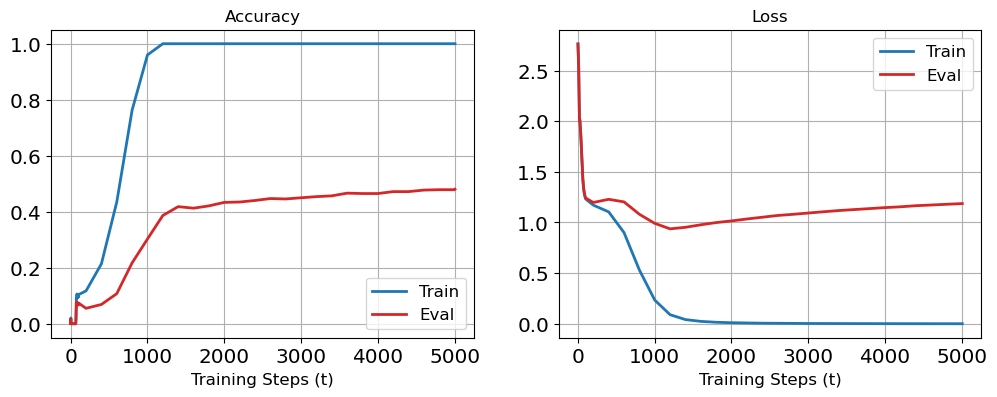

Number of training epochs & steps: 834 5004

Train loss : 2.852225 | Train accuracy : 0.000000 | Test loss : 2.853448 | Test accuracy : 0.000000 | lr = 0.001


Training:   0%|          | 0/834 [00:00<?, ?it/s]


Train loss : 2.513658 | Train accuracy : 0.000000 | Test loss : 2.513910 | Test accuracy : 0.000000 | lr = 0.001


Training:   4%|▍         | 34/834 [00:25<03:07,  4.27it/s]


Train loss : 1.042197 | Train accuracy : 0.256552 | Test loss : 1.242385 | Test accuracy : 0.086657 | lr = 0.001


Training:   8%|▊         | 67/834 [00:31<02:53,  4.43it/s]


Train loss : 0.097393 | Train accuracy : 0.979310 | Test loss : 0.686596 | Test accuracy : 0.568088 | lr = 0.001


Training:  12%|█▏        | 101/834 [00:37<02:39,  4.60it/s]


Train loss : 0.005322 | Train accuracy : 1.000000 | Test loss : 0.576915 | Test accuracy : 0.683631 | lr = 0.001


Training:  16%|█▌        | 134/834 [00:43<02:44,  4.26it/s]


Train loss : 0.002159 | Train accuracy : 1.000000 | Test loss : 0.560845 | Test accuracy : 0.712517 | lr = 0.001


Training:  20%|██        | 167/834 [00:49<02:35,  4.29it/s]


Train loss : 0.001212 | Train accuracy : 1.000000 | Test loss : 0.553334 | Test accuracy : 0.724897 | lr = 0.001


Training:  24%|██▍       | 200/834 [00:56<02:42,  3.90it/s]


Train loss : 0.000784 | Train accuracy : 1.000000 | Test loss : 0.549449 | Test accuracy : 0.735901 | lr = 0.001


Training:  28%|██▊       | 234/834 [01:02<02:15,  4.43it/s]


Train loss : 0.000549 | Train accuracy : 1.000000 | Test loss : 0.548482 | Test accuracy : 0.745530 | lr = 0.001


Training:  32%|███▏      | 267/834 [01:08<02:09,  4.38it/s]


Train loss : 0.000406 | Train accuracy : 1.000000 | Test loss : 0.546078 | Test accuracy : 0.751032 | lr = 0.001


Training:  36%|███▌      | 301/834 [01:14<01:54,  4.65it/s]


Train loss : 0.000311 | Train accuracy : 1.000000 | Test loss : 0.545759 | Test accuracy : 0.759285 | lr = 0.001


Training:  40%|████      | 334/834 [01:21<02:16,  3.66it/s]


Train loss : 0.000244 | Train accuracy : 1.000000 | Test loss : 0.544782 | Test accuracy : 0.759285 | lr = 0.001


Training:  44%|████▍     | 367/834 [01:28<01:53,  4.11it/s]


Train loss : 0.000196 | Train accuracy : 1.000000 | Test loss : 0.544505 | Test accuracy : 0.768913 | lr = 0.001


Training:  48%|████▊     | 401/834 [01:34<01:32,  4.67it/s]


Train loss : 0.000160 | Train accuracy : 1.000000 | Test loss : 0.543801 | Test accuracy : 0.771664 | lr = 0.001


Training:  52%|█████▏    | 434/834 [01:40<01:32,  4.32it/s]


Train loss : 0.000132 | Train accuracy : 1.000000 | Test loss : 0.544033 | Test accuracy : 0.777166 | lr = 0.001


Training:  56%|█████▌    | 467/834 [01:47<01:29,  4.10it/s]


Train loss : 0.000111 | Train accuracy : 1.000000 | Test loss : 0.544479 | Test accuracy : 0.781293 | lr = 0.001


Training:  60%|██████    | 501/834 [01:53<01:10,  4.75it/s]


Train loss : 0.000093 | Train accuracy : 1.000000 | Test loss : 0.544312 | Test accuracy : 0.784044 | lr = 0.001


Training:  64%|██████▍   | 534/834 [02:00<01:11,  4.19it/s]


Train loss : 0.000079 | Train accuracy : 1.000000 | Test loss : 0.543968 | Test accuracy : 0.784044 | lr = 0.001


Training:  68%|██████▊   | 567/834 [02:06<01:04,  4.15it/s]


Train loss : 0.000068 | Train accuracy : 1.000000 | Test loss : 0.544633 | Test accuracy : 0.784044 | lr = 0.001


Training:  72%|███████▏  | 601/834 [02:12<00:49,  4.71it/s]


Train loss : 0.000058 | Train accuracy : 1.000000 | Test loss : 0.544963 | Test accuracy : 0.788171 | lr = 0.001


Training:  76%|███████▌  | 634/834 [02:18<00:45,  4.37it/s]


Train loss : 0.000050 | Train accuracy : 1.000000 | Test loss : 0.544740 | Test accuracy : 0.790922 | lr = 0.001


Training:  80%|███████▉  | 667/834 [02:24<00:39,  4.21it/s]


Train loss : 0.000044 | Train accuracy : 1.000000 | Test loss : 0.545458 | Test accuracy : 0.795048 | lr = 0.001


Training:  84%|████████▍ | 701/834 [02:31<00:27,  4.76it/s]


Train loss : 0.000038 | Train accuracy : 1.000000 | Test loss : 0.545673 | Test accuracy : 0.796424 | lr = 0.001


Training:  88%|████████▊ | 734/834 [02:38<00:23,  4.26it/s]


Train loss : 0.000033 | Train accuracy : 1.000000 | Test loss : 0.545689 | Test accuracy : 0.800550 | lr = 0.001


Training:  92%|█████████▏| 767/834 [02:44<00:15,  4.26it/s]


Train loss : 0.000029 | Train accuracy : 1.000000 | Test loss : 0.546233 | Test accuracy : 0.803301 | lr = 0.001


Training:  96%|█████████▌| 801/834 [02:50<00:07,  4.63it/s]


Train loss : 0.000026 | Train accuracy : 1.000000 | Test loss : 0.547263 | Test accuracy : 0.804677 | lr = 0.001


Training: 100%|█████████▉| 833/834 [02:56<00:00,  5.56it/s]


Train loss : 0.000023 | Train accuracy : 1.000000 | Test loss : 0.547148 | Test accuracy : 0.804677 | lr = 0.001


Training: 100%|██████████| 834/834 [02:56<00:00,  4.71it/s]


Train loss : 0.000023 | Train accuracy : 1.000000 | Test loss : 0.547218 | Test accuracy : 0.804677 | lr = 0.001


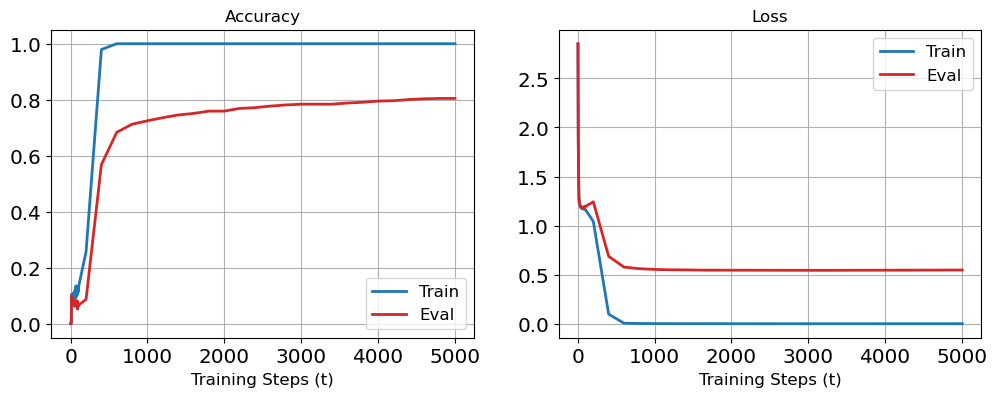

In [12]:
###############################################################################
# 4) PARTIE 4.3 : Mélange binaire/ternaire (p=11, operation_orders=[2,3])
#    => Diviser le dataset manuellement (moitié binaire, moitié ternaire)
#       ... puis entraîner LSTM et GPT ... 
###############################################################################

import torch
from data import get_arithmetic_dataset

def get_mixed_bin_tern_dataset(p=11, operator="+", r_train=0.5, seed=0):
    """
    Extrait un dataset combinant eq_position=3 (binaire) et eq_position=5 (ternaire).
    On veut un train avec ~50% binaire + 50% ternaire, 
    et un val set identique. 
    Cf. instructions de l'énoncé.
    """
    from train import Arguments
    args = Arguments()
    args.p = p
    args.operator = operator
    args.r_train = 1.0  # On prend tout, on split manuellement
    args.operation_orders = [2,3]
    args.seed = seed

    (full_dataset, _), tokenizer, maxlen, pad_idx = get_arithmetic_dataset(
        p, p, operator, 1.0, [2,3], seed=seed
    )
    # eq_positions => 3 (binaire) ou 5 (ternaire)
    idx_bin = [i for i in range(len(full_dataset)) if full_dataset[i][2]==3]
    idx_ter = [i for i in range(len(full_dataset)) if full_dataset[i][2]==5]
    bin_subset = torch.utils.data.Subset(full_dataset, idx_bin)
    ter_subset = torch.utils.data.Subset(full_dataset, idx_ter)

    # On fait un random split proportion r_train sur bin, r_train sur ter
    # => r_train correspond à la fraction en train 
    from torch.utils.data import random_split
    n_bin = len(bin_subset)
    train_bin_len = int(r_train * n_bin)
    val_bin_len   = n_bin - train_bin_len
    bin_train, bin_val = random_split(bin_subset, [train_bin_len, val_bin_len], generator=torch.Generator().manual_seed(seed))

    n_ter = len(ter_subset)
    train_ter_len = int(r_train * n_ter)
    val_ter_len   = n_ter - train_ter_len
    ter_train, ter_val = random_split(ter_subset, [train_ter_len, val_ter_len], generator=torch.Generator().manual_seed(seed))

    # Combine
    from torch.utils.data import ConcatDataset
    train_dataset = ConcatDataset([bin_train, ter_train])
    val_dataset   = ConcatDataset([bin_val,   ter_val])

    return train_dataset, val_dataset, tokenizer, maxlen, pad_idx


def train_mixed_bin_tern(p=11, operator="+", r_train=0.5, seed=0, model_type="lstm"):
    """
    Entraîne un seul modèle (LSTM ou GPT) sur le dataset mixte 
    binaire/ternaire, p=11, r_train=0.5.
    """
    from train import Arguments
    args = Arguments()
    args.p = p
    args.operator = operator
    args.r_train = r_train # mais on va l'ignorer pour data, on a un data custom
    args.operation_orders = [2,3]
    args.seed = seed
    args.device=device
    args.model=model_type
    args.num_layers=2
    args.embedding_size=64
    if model_type=="lstm":
        args.hidden_size=64
    args.n_steps=5000
    args.train_batch_size=128
    args.eval_batch_size=512
    args.log_dir="./logs_mixed"
    args.exp_name=f"mixed_{model_type}_p{p}_seed{seed}"
    args.verbose=True

    # On récupère un dataset custom:
    train_dataset, val_dataset, tokenizer, maxlen, pad_idx = get_mixed_bin_tern_dataset(
        p, operator, r_train, seed
    )
    # On construit manuellement DataLoader
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=args.eval_batch_size,  shuffle=False)

    # On appelle la fonction train(...) du module trainer_solution, 
    # mais on doit nous-même créer le modèle, l'optimizer, etc. 
    # ou on essaie de réutiliser "train(args)" => alors on doit patcher
    # train.py pour qu'il accepte un "custom dataset" en paramètre.
    # Pour illustrer, on va faire "train(args)" et forcer la data 
    # (vous adapterez si besoin).
    
    # Trick: On modifie un petit peu "train.py" ou on fait un contournement
    # direct pour appeler "train_loop_only(...)"
    
    # 1) On crée le modèle (LSTM ou GPT).
    from lstm_solution import LSTMLM
    from gpt_solution import GPT
    vocabulary_size = len(tokenizer)
    if model_type=="lstm":
        model = LSTMLM(vocabulary_size, args.embedding_size, args.hidden_size, args.num_layers,
                       dropout=args.dropout, padding_index=pad_idx,
                       bias_lstm=True, bias_classifier=args.bias_classifier,
                       share_embeddings=args.share_embeddings)
    else:
        model = GPT(num_heads=4, num_layers=args.num_layers,
                    embedding_size=args.embedding_size, vocabulary_size=vocabulary_size,
                    sequence_length=maxlen,
                    multiplier=4, dropout=0.0, non_linearity="gelu",
                    padding_index=pad_idx, bias_attention=True, bias_classifier=args.bias_classifier,
                    share_embeddings=args.share_embeddings)

    model.to(device)

    # 2) Create optimizer
    import torch.optim as optim
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    # Dummy scheduler
    from train import DummyScheduler
    scheduler = DummyScheduler(optimizer)

    # 3) Appel du "train_loop_only"
    from trainer_solution import train as train_loop
    # => train_loop(model, train_loader, train_loader_eval, test_loader, optimizer, scheduler, ...)

    checkpoint_path = os.path.join(args.log_dir, args.exp_name)
    os.makedirs(checkpoint_path, exist_ok=True)

    all_metrics = train_loop(
        model, 
        train_loader, 
        train_loader,  # for eval on train
        val_loader, 
        optimizer, scheduler, 
        device,
        args.exp_name, checkpoint_path,
        n_steps=args.n_steps,
        eval_first=100,
        eval_period=200,
        print_step=200,
        save_model_step=1000,
        save_statistic_step=1000,
        verbose=True
    )
    # On peut tracer
    from plotter import plot_loss_accs
    plot_loss_accs(all_metrics, multiple_runs=False, fileName=args.exp_name, filePath=checkpoint_path, show=True)
    
    return all_metrics, checkpoint_path


# EXEMPLE D'UTILISATION:
mets_lstm, ckp_lstm = train_mixed_bin_tern(model_type="lstm", seed=0)
mets_gpt,  ckp_gpt  = train_mixed_bin_tern(model_type="gpt",  seed=0)
# => Ensuite, vous regardez si binaire (eq_pos=3) s'apprend plus vite que ternaire (eq_pos=5).


In [13]:
###############################################################################
# 5) PARTIE 4.4 : MISE A L'ECHELLE DU MODELE (L, d) => (L, d) ∈ {1,2,3} × {26,27,28}
###############################################################################

def run_scaling_experiments(model_type="lstm", L_values=[1,2,3], d_values=[26,27,28], seed=0):
    """
    Lance 3×3 expériences, pour L ∈ {1,2,3} et d ∈ {26,27,28}, 
    tout le reste inchangé (p=31, r_train=0.5, etc.).
    """
    results = {}
    for L in L_values:
        for d in d_values:
            args = Arguments()
            args.p=31
            args.operator="+"
            args.r_train=0.5
            args.operation_orders=2
            args.train_batch_size=512
            args.eval_batch_size=4096
            args.model=model_type
            args.num_layers=L
            args.embedding_size=d
            if model_type=="lstm":
                args.hidden_size=d
            args.dropout=0.0
            args.optimizer="adamw"
            args.lr=1e-3
            args.weight_decay=1e-3
            args.n_steps=10_000+1
            args.eval_period=500
            args.print_step=500
            args.exp_name=f"scaling_{model_type}_L{L}_d{d}_seed{seed}"
            args.log_dir="./logs_scaling"
            args.seed=seed
            args.device=device
            args.verbose=False

            mets, ckp = train(args)
            results[(L,d)] = (mets, ckp)

    return results

# EXEMPLE:
res_lstm_scaling = run_scaling_experiments("lstm", [1,2,3], [26,27,28], seed=0)
res_gpt_scaling  = run_scaling_experiments("gpt",  [1,2,3], [26,27,28], seed=0)
# => On récupère ensuite le nombre de paramètres (hors embeddings) 
#    et on trace la performance vs. P. 


Training: 100%|██████████| 10001/10001 [10:59<00:00, 15.16it/s]


AssertionError: 

In [6]:
###############################################################################
# 6) PARTIE 4.5 : Variation batch_size B et T=2×10^4
###############################################################################

def run_batch_experiments(model_type="lstm", B_values=[25,26,27,28,29], seed=0):
    results = {}
    for B in B_values:
        args = Arguments()
        args.p=31
        args.operator="+"
        args.r_train=0.5
        args.operation_orders=2
        args.model=model_type
        args.n_steps=20000+1
        args.train_batch_size=B
        args.eval_batch_size=4096
        args.num_layers=2
        args.embedding_size=64
        if model_type=="lstm":
            args.hidden_size=64
        args.optimizer="adamw"
        args.lr=1e-3
        args.weight_decay=1e-3
        args.exp_name=f"batch_{model_type}_B{B}_seed{seed}"
        args.log_dir="./logs_batch"
        args.seed=seed
        args.device=device
        args.verbose=False

        mets, ckp = train(args)
        results[B] = (mets, ckp)
    return results

# EX. => run_batch_experiments("lstm", [32,64,128], seed=0)
# Puis on analyse la performance en coupant l'entraînement à alpha*T steps, etc.


In [7]:
###############################################################################
# 7) PARTIE 4.6 : Régularisation (weight_decay)
#    => Ex: T=4×10^4 steps, wd ∈ {0.25, 0.5, 0.75,1.0}, et on trace la norme ℓ2 ...
###############################################################################

def run_weight_decay_experiments(wd_values=[0.25, 0.5, 0.75, 1.0], seed=0):
    results={}
    for wd in wd_values:
        args=Arguments()
        args.p=31
        args.operator="+"
        args.r_train=0.5
        args.operation_orders=2
        args.model="lstm"
        args.n_steps=40000+1
        args.weight_decay=wd
        args.exp_name=f"wd_lstm_{wd}_seed{seed}"
        args.log_dir="./logs_wd"
        args.seed=seed
        args.device=device
        args.verbose=False

        mets, ckp = train(args)
        results[wd] = (mets, ckp)
    return results

# => On pourra extraire la norme ℓ2 des paramètres si on modifie "eval_model" 
#    pour retourner la norme.


In [8]:
###############################################################################
# 8) PARTIE 4.7 : Interprétabilité GPT (Poids d'attention)
###############################################################################

def visualize_gpt_attention(model, tokenizer, sequences):
    """
    Montre un exemple de fonction pour visualiser 
    la matrice d'attentions (B, num_layers, num_heads, seq_len, seq_len).

    'model' : GPT entraîné
    'tokenizer' : votre tokenizer
    'sequences' : liste de strings (ex: ["[BOS] 3 + 4 = ?"])
    """
    model.eval()

    # 1) Tokenize
    encoded_batch = []
    max_len = 0
    for seq in sequences:
        # Supposez tokenizer.encode(seq) => liste d'IDs
        # Vous adapterez selon votre tokenizer
        ids = tokenizer.encode(seq)  
        if len(ids)>max_len:
            max_len = len(ids)
        encoded_batch.append(ids)

    # Padding
    pad_id = tokenizer.pad_token_id if hasattr(tokenizer, "pad_token_id") else 0
    batch_l = []
    for ids in encoded_batch:
        pad_len = max_len - len(ids)
        new_ids = ids + [pad_id]*pad_len
        batch_l.append(new_ids)
    batch_tensor = torch.tensor(batch_l, dtype=torch.long, device=device)

    # 2) Forward => (logits, (hidden_states, attentions))
    with torch.no_grad():
        logits, (hidden_states, attentions) = model(batch_tensor)
        # attentions : (B, num_layers, num_heads, seq_len, seq_len)

    import matplotlib.pyplot as plt
    import seaborn as sns

    B = batch_tensor.size(0)
    num_layers = attentions.size(1)
    num_heads  = attentions.size(2)

    for i in range(B):
        # get the i-th item
        att_i = attentions[i]  # shape (num_layers, num_heads, seq_len, seq_len)
        # label tokens
        tokens_ids = batch_l[i]
        # decode if possible
        tokens_str = tokenizer.decode(tokens_ids)  # ou autre

        fig, axes = plt.subplots(num_layers, num_heads, figsize=(4*num_heads, 4*num_layers))
        fig.suptitle(f"Attention for sample {i}")

        for layer in range(num_layers):
            for head in range(num_heads):
                mat = att_i[layer, head].cpu().numpy()
                ax = axes[layer, head] if num_layers>1 else axes[head]  # si single layer

                sns.heatmap(mat, vmin=0, vmax=1, cmap="Blues", ax=ax)
                ax.set_title(f"Layer={layer}, Head={head}", fontsize=8)
                # label x,y si vous voulez
        plt.tight_layout()
        plt.show()


In [9]:

from checkpointing import get_all_checkpoints
my_ckpt_dir = "./logs_verif/verif_gpt_seed0"
all_models, all_mets = get_all_checkpoints(my_ckpt_dir, "verif_gpt_seed0", just_files=False)
# supposez all_models[-1] = (last_model, last_step)
gpt_model = all_models[-1][0]

# Choisissez 2 échantillons, ex:
seqs = ["BOS 3 + 5 = ???", "BOS 7 + 2 = ???"]
visualize_gpt_attention(gpt_model, tokenizer, seqs)


FileNotFoundError: [Errno 2] No such file or directory: './logs_verif/verif_gpt_seed0'